# Introduction

Why this project? 

I've been tinkering about getting a new laptop as mine is nearly 10 years old, and I'll probably have to invest some time into looking up my options, I might as well just do it here, killing two birds with one stone. Time is a precious thing. 

Gameplan:

*   Get the data by scraping notebook.hu (~1-2 hours tops)
*   Clean the data (~2 hours)
*   Basic EDA, data viz (~1-2 hours)
*   Feature engineering (all the (remaining) time)
*   Benchmarking (~30min)
*   Hyperparam opt(~1 hour)
*   Deployment (~1-2 hours)

If I manage not to cross these time-boundaries, I'll finish the project under 10 hours. 

I should build a pipeline as fast as I can, and then assign the remaining time between eda, feature eng and hyperparam opt. Maybe I will delay the deployment part as I haven't done it previously (and also because I will probably have to use it in a school project thats deadline is close)


# Webscraping

In [ ]:
# Tasks: 
# 1. scrape data from a webshop/ecommerce site
# 2. do some basic analysis
# 3. build a model
# 4. deploy the model

# https://www.notebook.hu/notebook?page=1&limit=72 , total 6 pages atm, most popular in front

# scraped site: notebook.hu
# Checked /robots.txt, as far as I've seen it doesn't disallow scraping /notebook, so I'm good to go
# Note to myself: make sure I don't harm/overload the sites services. 

import requests
from bs4 import BeautifulSoup
import time 

productlinks = []
for i in range(1,6):
    limit=72 #other option is 36
    baseurl = f"https://www.notebook.hu"
    pageurl = f"https://www.notebook.hu/notebook?page={i}&limit=72" 
    html = requests.get(pageurl).text
    time.sleep(3) # being nice to the server

    soup=BeautifulSoup(html,'html.parser')
    productlist = soup.find_all("div",{"class":"item-new"})
  
    
    for product in productlist:
        product_link  = baseurl + '/' + product.find("div",{"class":"thumb-wrapper"}).find('a').get('href')
        productlinks.append(product_link)
    

In [ ]:
items_data = [] 

for link in productlinks:
    values_dict = {}
    html = requests.get(link).text
    time.sleep(3)
    soup = BeautifulSoup(html,'html.parser')
    values_dict['link'] = link
    for div in soup.find_all("div", {"class": "leiras"}):
        try:
           values_dict['Notebook neve'] = soup.find("div", {"class": "product-name"}).text
        except:
            values_dict['Notebook neve'] = 'Name not found'
        for li in div.find_all('li'): 
            label = li.find("span", {"class": "label"}).text
            try:
                value = li.find("span", {"class": "value"}).text
                values_dict[label] = value
            except:
                values_dict[label] = None
            try:
                values_dict['Raktáron'] = soup.find("div", {"class":"product-sales-container"}).find("div", {"class":"stock-info"}).text
            except:
                values_dict['Raktáron'] = None

            try:
                values_dict['Ár'] = soup.find("span", {"class":"regular-price"}).text
            except:
                values_dict['Ár'] = None

            try:
                values_dict['Régi Ár'] = soup.find("span", {"class":"old-price"}).text
            except:
                values_dict['Régi Ár'] = None

            try:
                values_dict['Akciós Ár'] = soup.find("span", {"class":"special-price"}).text
            except:
                values_dict['Akciós Ár'] = None


    items_data.append(values_dict)



In [ ]:
import pandas as pd

df = pd.DataFrame(items_data)
df

,link,Notebook neve,Raktáron,Ár,Régi Ár,Akciós Ár,Processzor leírás,Operációs rendszer,Memória,Háttértár,Grafikus vezérlő,Kijelző,Képfrissítés,Fényerő,LAN típus,Wi-Fi,Bluetooth,HDMI normál,USB 3.1,USB3.1 Type-C,Thunderbolt támogatás,Lighting csatlakozó,Optikai meghajtó,Billentyűzet,Audio leírás,Akkumulátor leírás,Méret,Súly,Garancia,Webkamera,USB 2.0,USB 3.0,Kártya olvasó,Extrák,További extrák,USB3.0 Type-C,Displayport mini,Érintő kijelző,HSDPA,VGA
0,https://www.notebook.hu/asus-rog-strix-g15-g51...,\nAsus ROG Strix G15 G512LI (G512LI-HN094) fek...,Raktáron,349 900 Ft,None,None,"Intel® Core™ i5-10300H Processor (8M Cache, up...",Operációs rendszer nélkül,8GB DDR4 2933MHz RAM,512GB M.2 PCIe SSD,NVIDIA® GeForce™ GTX 1650Ti 4GB GDDR6,"15.6"" FullHD (1920 x 1080) matt WVA LCD (144Hz)",144 Hz,250 nit,1000Mbps,802.11 ax,v 5.1,1 db,3 db,1 db,Nem,Nem,USB (vásárolható),"Világítás, Nincs numpad, Magyar kiosztású","2 x 1.5W hangszóró W/O Smart AMP technológia, ...",3 cellás 48Whr beépített,360.00x275.00x25.80 mm,2.30 kg,36 hónap,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,https://www.notebook.hu/msi-gf65-thin-10ue-9s7...,\nMSI GF65 Thin 10UE (9S7-16W212-025) Fekete\n,Raktáron,None,Régi ár: 469 900 Ft,449 900 Ft,"Intel® Core™ i5-10200H Processor (8M Cache, up...",FreeDos,16GB (2x8) DDR4 3200MHz RAM,512 GB NVMe PCIe Gen3x4 SSD,NVIDIA® GeForce™ RTX 3060 6GB GDDR6,"15.6"" FullHD (1920 x 1080) matt IPS LCD",144 Hz,NaN,1000Mbps,802.11 ax,v 5.1,1 db,2 db,2 db,Nem,Nem,USB (vásárolható),"Világítás, Nincs numpad, Magyar kiosztású",1 db Mikrofon bemenet/Fejhallgató kimenet Comb...,3 cellás 51Whr beépített,359.00x254.00x21.70 mm,1.86 kg,36 hónap,HD type (30fps@720p),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,https://www.notebook.hu/msi-gf63-thin-10scsr-1...,\nMSI GF63 Thin 10SCSR (9S7-16R412-1017HU) Fek...,Raktáron,None,Régi ár: 349 900 Ft,309 900 Ft,"Intel® Core™ i5-10300H Processor (8M Cache, up...",FreeDos,8GB DDR4 2666MHz RAM,512 GB NVMe PCIe SSD,NVIDIA® GeForce™ GTX 1650Ti (Max-Q) 4GB GDDR6,"15.6"" FullHD (1920 x 1080) matt IPS-level LCD ...",144 Hz,NaN,1000Mbps,802.11 ax,v 5,1 db,3 db,1 db,Nem,Nem,USB (vásárolható),"Világítás, Nincs numpad, Magyar kiosztású","2x 2W Hangszóró, 1 db Mikrofon bemenet, 1 db F...",3 cellás 51Whr beépített,359.00x254.00x21.70 mm,1.86 kg,36 hónap,Beépített HD Webkamera (30fps@720p),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,https://www.notebook.hu/dell-g5-5500-g5500fi5u...,\nDell G5 5500 (G5500FI5UA1) Fekete\n,Raktáron,None,Régi ár: 369 900 Ft,309 900 Ft,"Intel® Core™ i5-10300H Processor (8M Cache, up...",Ubuntu (Linux),8GB (2x4) DDR4 2933MHz RAM,512GB M.2 PCIe SSD,NVIDIA® GeForce™ GTX 1650Ti 4GB GDDR6,"15.6"" FullHD (1920 x 1080) matt WVA LCD",60 Hz,250 nit,1000Mbps,802.11 ax,v 5.1,1 db,NaN,1 db,Nem,Nem,USB (vásárolható),"Világítás, Magyar kiosztású",Realtek ALC3254 Nahimic 3D Audio technológia (...,4 cellás 68Whr beépített,364.46x254.00x28.18 mm,2.55 kg,36 hónap,HD Webkamera (beépített),2 db,1 db,SD,Ujjlenyomat olvasó,NaN,NaN,NaN,NaN,NaN,NaN
4,https://www.notebook.hu/asus-vivobook-15-m509d...,\nAsus VivoBook 15 M509DA (M509DA-BR988) Szürke\n,Raktáron,179 900 Ft,None,None,AMD® Ryzen™ 3-3250U Quad-core 2.6 GHz Mobile A...,Operációs rendszer nélkül,4GB DDR4 2666MHz RAM,256 GB M.2 NVMe™ PCIe® 3.0 SSD,AMD Radeon™ Graphics,"15.6"" HD (1366 x 768) matt LCD",NaN,200 nit,NaN,802.11 ac,v 4.1,1 db,1 db,1 db,Nem,Nem,USB (vásárolható),Magyar kiosztású,"Audio by ICEpower®, SonicMaster (Close), Beépí...",2 cellás 32Whr beépített,360.00x235.00x22.90 mm,1.90 kg,24 hónap,Beépített VGA Webkamera,NaN,2 db,microSD,TPM chip,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
355,https://www.notebook.hu/dell-latitude-14-5420-...,\nDELL Latitude 14 5420 (NO31L542014EMEA) szür...,Raktáron,558 900 Ft,None,None,"Intel® Core™ i7-1185G7 Processor(12M Cache, up...",Microsoft Windows 10 Professional,8GB DDR4 266

In [ ]:
df.to_csv('dmlab_new.csv') # download scraped data as csv

In [151]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re 
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.model_selection import train_test_split

! pip install https://github.com/pandas-profiling/pandas-profiling/archive/master.zip # restart runtime after this

df1 = pd.read_csv('notebook_data.csv', index_col=0)
df1.head(2)

,link,Notebook neve,Raktáron,Ár,Régi Ár,Akciós Ár,Processzor leírás,Operációs rendszer,Memória,Háttértár,Grafikus vezérlő,Kijelző,Képfrissítés,Fényerő,LAN típus,Wi-Fi,Bluetooth,HDMI normál,USB 3.1,USB3.1 Type-C,Thunderbolt támogatás,Lighting csatlakozó,Optikai meghajtó,Billentyűzet,Audio leírás,Akkumulátor leírás,Méret,Súly,Garancia,Webkamera,USB 2.0,USB 3.0,Kártya olvasó,Extrák,További extrák,USB3.0 Type-C,Displayport mini,Érintő kijelző,HSDPA,VGA
0,https://www.notebook.hu/asus-rog-strix-g15-g51...,\nAsus ROG Strix G15 G512LI (G512LI-HN094) fek...,Raktáron,349 900 Ft,NaN,NaN,"Intel® Core™ i5-10300H Processor (8M Cache, up...",Operációs rendszer nélkül,8GB DDR4 2933MHz RAM,512GB M.2 PCIe SSD,NVIDIA® GeForce™ GTX 1650Ti 4GB GDDR6,"15.6"" FullHD (1920 x 1080) matt WVA LCD (144Hz)",144 Hz,250 nit,1000Mbps,802.11 ax,v 5.1,1 db,3 db,1 db,Nem,Nem,USB (vásárolható),"Világítás, Nincs numpad, Magyar kiosztású","2 x 1.5W hangszóró W/O Smart AMP technológia, ...",3 cellás 48Whr beépített,360.00x275.00x25.80 mm,2.30 kg,36 hónap,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,https://www.notebook.hu/msi-gf65-thin-10ue-9s7...,\nMSI GF65 Thin 10UE (9S7-16W212-025) Fekete\n,Raktáron,NaN,Régi ár: 469 900 Ft,449 900 Ft,"Intel® Core™ i5-10200H Processor (8M Cache, up...",FreeDos,16GB (2x8) DDR4 3200MHz RAM,512 GB NVMe PCIe Gen3x4 SSD,NVIDIA® GeForce™ RTX 3060 6GB GDDR6,"15.6"" FullHD (1920 x 1080) matt IPS LCD",144 Hz,NaN,1000Mbps,802.11 ax,v 5.1,1 db,2 db,2 db,Nem,Nem,USB (vásárolható),"Világítás, Nincs numpad, Magyar kiosztású",1 db Mikrofon bemenet/Fejhallgató kimenet Comb...,3 cellás 51Whr beépített,359.00x254.00x21.70 mm,1.86 kg,36 hónap,HD type (30fps@720p),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Data Cleaning

In [152]:
def find_gpu_brand(col_value):
    brands = ['Intel', 'NVIDIA', 'AMD', 'Radeon', 'Apple', 'Qualcomm']
    
    for brand in brands:
        if brand in col_value:
            return brand
    
    return 'no brand'

def data_cleaning(df1):
    
    # fill price with sale price, keep only the number, not the currency
    df1['Ár'] = df1['Ár'].fillna(df1['Akciós Ár'])
    df1['Ár'] = df1['Ár'].str.replace(' ', '').str.extract('(\d+)')

    # see if the item is in the warehouse
    df1['Raktáron'] = df1['Raktáron'].apply(lambda x: 1 if x=='Raktáron' else 0)

    # clean operating system column
    df1['Operációs rendszer'] = df1['Operációs rendszer'].apply(lambda x: 'Windows' if 'Windows' in str(x) else 'Linux' if 'Linux' in str(x) else x ).fillna('Operációs rendszer nélkül')

    # find the DDR type
    memory_words = df1['Memória'].str.split()
    
    # sometimes the 2nd word isn't the DDR
    items = []
    for item in memory_words:
        if 'DDR' in item[1]:
            items.append(item[1])
        elif 'DDR' in item[2]:
            items.append(item[2])
        elif 'DDR' in item[3]:
            items.append(item[3])
    
    df1['Memória DDR'] = items  

    # clean memory column, keep only digit + 'GB'
    df1['Memória'] = df1['Memória'].str.replace(' ', '').str.extract(r'(\d+[GB]+)')

    # get storage type
    df1['Háttértár típus_SSD'] = df1['Háttértár'].apply(lambda x: 1 if 'SSD' in x else 0)
    df1['Háttértár típus_HDD'] = df1['Háttértár'].apply(lambda x: 1 if 'HDD' in x else 0)

    # get storage size
    # replace 512 with 512GB and 1TB with 1000GB
    df1['Háttértár'] = df1['Háttértár'].str.replace(' ', '').str.extract(r'(\d+(GB|TB)*)')
    df1['Háttértár'] = df1['Háttértár'].str.replace(r'^512$', '512GB', regex=True)
    df1['Háttértár'] = df1['Háttértár'].str.replace('1TB', '1000GB')

    # differentiate CPU brand and type
    proc = [x for x in df1['Processzor leírás'].str.replace('™', '®').str.replace('(', '®').str.replace(',', '®').str.replace('-', '®').str.replace(' ', '®').str.split('®')] 
    df1['Processzor márka'] = [item[0] for item in proc]
    df1['Processzor típus'] = [item[1] for item in proc]

    graph_word = [x for x in df1['Grafikus vezérlő'].str.replace('™', '®').str.replace(' ', '®').str.split('®')]
    
    # remove empty items after split
    for item in graph_word:
        for sub_item in item:
             if sub_item == '':
                item.remove(sub_item)

    # find the brand of the GPU
    df1['Grafikus márka'] = df1['Grafikus vezérlő'].apply(lambda x: find_gpu_brand(x))
    
    # find type of 
    df1['Grafikus típus'] = [item[1] if len(item)>1 is not None else None for item in graph_word]
    
    # find size of VRAM, fill empty with 0GB as otherwise I feel it would've been added 
    df1['Grafikus memória'] = df1['Grafikus vezérlő'].str.extract(r'((\d+GB)+)')[0].fillna('0GB')

    # get display size
    df1['Kijelző méret'] = df1['Kijelző'].str.extract(r'^(.+?)"')

    # get display resolution
    df1['Kijelző felbontás'] = df1['Kijelző'].str.extract(r'(\d+ x \d+)').fillna('1920 x 1080') # fill with most common (1920x1080)

    # get refresh rate, fill missing with 60 as it's the default value for laptops
    df1['Kijelző frissítés'] = df1['Kijelző'].str.extract(r'(\d+ ?Hz)')
    df1['Kijelző frissítés'] = df1['Kijelző frissítés'].str.replace('Hz', '').fillna(60) 
    df1['Képfrissítés'] = df1['Képfrissítés'].str.extract(r'(\d+)').fillna(60)

    # get brightness, fill missing with 220 (default for laptops)
    df1['Fényerő'] = df1['Fényerő'].str.extract(r'(\d+)').fillna(220)

    # get number of USB 3.1 and USB 3.1 Type-C ports, if missing fill with 0 
    df1['USB 3.1'] = df1['USB 3.1'].str.extract(r'(\d+)').fillna(0)
    df1['USB3.1 Type-C'] = df1['USB3.1 Type-C'].str.extract(r'(\d+)').fillna(0)
    
    # Thunderbolt and Lightning support
    df1['Thunderbolt támogatás'] = df1['Thunderbolt támogatás'].apply(lambda x: 0 if x=='Nem' else 1)
    df1['Lighting csatlakozó'] = df1['Lighting csatlakozó'].apply(lambda x: 0 if x=='Nem' else 1)

    # Keyboard light
    df1['Világítás'] = df1['Billentyűzet'].apply(lambda x: 1 if 'Világítás' in str(x) else 0)
    
    # Hungarian keyboard 
    df1['Magyar kiosztás'] = df1['Billentyűzet'].apply(lambda x: 1 if 'Magyar kiosztás' in str(x) else 0)
    
    # is there Numpad
    df1['Numpad'] = df1['Billentyűzet'].apply(lambda x: 0 if 'Nincs numpad' in str(x) else 1)

    # number of battery cells, battery performance
    df1['Akkumulátor cellák'] = df1['Akkumulátor leírás'].str.extract(r'(\d+) cellás').fillna(1)
    df1['Akkumulátor teljesítmény'] = df1['Akkumulátor leírás'].str.extract(r'(\d+)Whr')    #.fillna()

    # size in every direction
    df1[['Méret 1', 'Méret 2', 'Méret 3']] = df1['Méret'].str.replace('mm', '').str.split('x', expand=True)

    # weight of the notebook, fill na with median value
    df1['Súly'] = df1['Súly'].str.replace('kg', '')
    df1['Súly'] = df1['Súly'].fillna(df1['Súly'].median()) # in kilogramms

    # warranty (either 24 or 36) in months
    df1['Garancia'] = df1['Garancia'].str.extract(r'(\d+)') 

    # does it have a HD Webcam
    df1['HD Kamera'] = df1['Webkamera'].apply(lambda x: 1 if 'HD' in str(x) else 0)

    # number of USB 3.0 ports
    df1['USB 3.0'] = df1['USB 3.0'].str.extract(r'(\d+)').fillna(0)

    # does it have a fingerprint scanner
    df1['Ujjlenyomat'] = df1['Extrák'].apply(lambda x: 1 if 'Ujjlenyomat' in str(x) else 0)

    # does it have a TPM Chip
    df1['TPM Chip'] = df1['Extrák'].apply(lambda x: 1 if 'TPM chip' in str(x) else 0)

    # number of USB 2.0 ports
    df1['USB 2.0'] = df1['USB 2.0'].str.extract(r'(\d+)').fillna(0)

    # number of USB 3.0 Type-C ports
    df1['USB3.0 Type-C'] = df1['USB3.0 Type-C'].str.extract(r'(\d+)').fillna(0)

    # fill missing Bluetooth with version 4 
    df1['Bluetooth'] = df1['Bluetooth'].fillna('v 4')

    # get brand and subtype from notebook name
    name_split = df1['Notebook neve'].str.split()
    notebook_brand = [item[0] for item in name_split]
    brand_subtype = [item[1] for item in name_split]

    df1['Notebook márka'] = notebook_brand
    df1['Notebook márka altípus'] = brand_subtype

    # some brands have both uppercase and lowercase versions, keep only one
    uppercase_brands = ['Acer', 'Asus', 'Apple', 'Dell', 'Lenovo']
    for brand in uppercase_brands:
        df1['Notebook márka'] = df1['Notebook márka'].replace(brand.upper(), brand)

    return df1

df1 = data_cleaning(df1)

Notes for data cleaning:

*   raktáron: 0/1
*   ár: right skewed
*   processzor leírás: if intel get type(i5), gen(G7), cache size(8M), clock(from 2 up to 4)
*   opre: win10, no os, freedos, ubuntu, apple, linux
*   memoria: size(8GB), hz(2666MHz)
*   hattertar: size(512GB) - watch out for TB !
*   grafikus vezerlo: high card(50) ..
*   kijelzo: size(15.6''), HD(FullHD), type(matt), type(LCD)
*   képfrissítés: conv to num
*   fényerő: missing 102 -> avg/med/most freq, conv to num
*   lan tipus: delete
*   wifi: delete
*   bluetooth: one hot
*   hdmi normal: delete
*   usb 3.1: conv to num
*   usb 3.1 type-c: conv to num
*   thunderbolt tamogatas: 0/1
*   optikai meghajto: one hot (few with dvd+-rw)
*   billentyuzet: vilagitas(0/1), numpad(0/1), kiosztás(hun/eng) 
	      - maybe not necessarily as only 6 distinct categories
*   audio: delete..
*   akkumulator: cellak szama(3), Whr(41)
*   meret: NUM x NUM x NUM
*   suly: conv to num
*   garancia: categorical(24/36)
*   USB 3.0: conv to num
*   kartya olvaso: one hot for all distinctively
*   webkamera: yes/no + hd/no hd
*   extrak: distinctively one-hot
*   USB 2.0: conv to num
*   tovabbi extrak: same as extrak
*   USB3.0 Type-C: conv to num
*   erinto: delete
*   displayport: delete
*   HSDPA: delete
*   VGA: delete

Converting some numbers like number of usb ports might be better represented by categorical features..

In [153]:
# overview of the features so that we can decide how to clean them
# pandas profiler usually takes too long, but in this case (<400 data points) it'll finish quite fast

from pandas_profiling import ProfileReport

profile = ProfileReport(df1)

profile.to_notebook_iframe()

Summary: 
- delete **link**: no insight
- delete **raktáron**: that one instance that is not in stock is not gonna make a difference
- **ár** is right skewed
- delete **régi ár, akciós ár** : no insight
- delete **processzor leírás** (no insight in this form, might use it to get some more information like number of cores)
- **opre**: great, missing values should be FreeDos i think !!
- **memória**: keep it as categorical 
- **háttértár**: keep it as categorical 
- delete **grafikus vezérlő**: no useful data in this form (already extracted)
- delete **kijelző**: no useful data in this form (already extracted)
- **képfrissítés**: missing values should be 60 !!
- **fényerő**: 220 nits is usually the value for lower tier laptops(missing values) !!
- delete **LAN típus**: only one value..
- **WiFi**: probably nothing important, might delete it
- **Bluetooth**: fill missing with v4 as its the worst ?!
- delete **HDMI normál**: only one value
- **USB 3.1**: fill missing with 0 !!
- **USB3.1 Type-C**: fill missing with 0 !!
- delete **lighting csatlakozó**: only one value
- delete **optikai meghajtó**: only 2 samples differ from most common case
- delete **billentyűzet, audio leírás, akkumulátor leírás, méret** as it's already extracted
- **súly**: missing values with median !!
- **garancia**: convert it to categorical !!
- delete **webkamera**: already extracted
- delete **USB 3.0**
- **kártya olvasó** convert it to (kind-of) one-hot-encoded !!
- **extrák** VR Ready, Dokkoló port categories are yet to be done
- **további extrák**: gyorsulásmérő, numberpad, fényérzékelő, giroszkóp, 810g, 810h
- delete **USB 2.0, displayport mini, USB3.0 Type-C**
- **HSDPA** if not none 1, else 0
- delete **VGA**
- **Processzor típus**: weird categories ..
- **Processzor Core**: 12MB ?? that sample is weird
- **Grafikus típus**: a lot of missing, why?
- **Grafikus memória**: lot of missing, why?
- **Kijelző felbontás**: missing values should be 1920x1080
- **Kijelző frissítés**: standard refresh rate for laptops is 60Hz, fill missings with that value
- **akkumulátor cella**: fill missing with 1
- **akkumulátor teljesítmény**: fill missing with median
- **méret** 1, 2, 3 has 4 missing values each -> go with median




In [154]:
df1.describe()

,Raktáron,Thunderbolt támogatás,Lighting csatlakozó,Háttértár típus_SSD,Háttértár típus_HDD,Világítás,Magyar kiosztás,Numpad,HD Kamera,Ujjlenyomat,TPM Chip
count,360.0,360.000000,360.0,360.000000,360.000000,360.000000,360.000000,360.000000,360.000000,360.000000,360.00000
mean,1.0,0.247222,0.0,0.983333,0.033333,0.775000,0.952778,0.502778,0.761111,0.338889,0.52500
std,0.0,0.431997,0.0,0.128197,0.179755,0.418164,0.212409,0.500688,0.426998,0.473991,0.50007
min,1.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
25%,1.0,0.000000,0.0,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.00000
50%,1.0,0.000000,0.0,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.00000
75%,1.0,0.000000,0.0,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000
max,1.0,1.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000


In [155]:
# group display size into bins
# convert to bins to ordinal categories

def bin_display_size(df1):
    bins = [10, 11, 12, 13, 14, 15, 16, 18]
    labels = [1,2,3,4,5,6,7]
    df1['binned_kijelzo'] = pd.cut(df1['Kijelző méret'].astype(float), bins=bins, labels=labels)
    
    return df1

df1 = bin_display_size(df1)

In [156]:
df1.head(2)

,link,Notebook neve,Raktáron,Ár,Régi Ár,Akciós Ár,Processzor leírás,Operációs rendszer,Memória,Háttértár,Grafikus vezérlő,Kijelző,Képfrissítés,Fényerő,LAN típus,Wi-Fi,Bluetooth,HDMI normál,USB 3.1,USB3.1 Type-C,Thunderbolt támogatás,Lighting csatlakozó,Optikai meghajtó,Billentyűzet,Audio leírás,Akkumulátor leírás,Méret,Súly,Garancia,Webkamera,USB 2.0,USB 3.0,Kártya olvasó,Extrák,További extrák,USB3.0 Type-C,Displayport mini,Érintő kijelző,HSDPA,VGA,Memória DDR,Háttértár típus_SSD,Háttértár típus_HDD,Processzor márka,Processzor típus,Grafikus márka,Grafikus típus,Grafikus memória,Kijelző méret,Kijelző felbontás,Kijelző frissítés,Világítás,Magyar kiosztás,Numpad,Akkumulátor cellák,Akkumulátor teljesítmény,Méret 1,Méret 2,Méret 3,HD Kamera,Ujjlenyomat,TPM Chip,Notebook márka,Notebook márka altípus,binned_kijelzo
0,https://www.notebook.hu/asus-rog-strix-g15-g51...,\nAsus ROG Strix G15 G512LI (G512LI-HN094) fek...,1,349900,NaN,NaN,"Intel® Core™ i5-10300H Processor (8M Cache, up...",Operációs rendszer nélkül,8GB,512GB,NVIDIA® GeForce™ GTX 1650Ti 4GB GDDR6,"15.6"" FullHD (1920 x 1080) matt WVA LCD (144Hz)",144,250,1000Mbps,802.11 ax,v 5.1,1 db,3,1,0,0,USB (vásárolható),"Világítás, Nincs numpad, Magyar kiosztású","2 x 1.5W hangszóró W/O Smart AMP technológia, ...",3 cellás 48Whr beépített,360.00x275.00x25.80 mm,2.30,36,NaN,0,0,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,DDR4,1,0,Intel,,NVIDIA,GeForce,4GB,15.6,1920 x 1080,144,1,1,0,3,48,360.00,275.00,25.80,0,0,0,Asus,ROG,6
1,https://www.notebook.hu/msi-gf65-thin-10ue-9s7...,\nMSI GF65 Thin 10UE (9S7-16W212-025) Fekete\n,1,449900,Régi ár: 469 900 Ft,449 900 Ft,"Intel® Core™ i5-10200H Processor (8M Cache, up...",FreeDos,16GB,512GB,NVIDIA® GeForce™ RTX 3060 6GB GDDR6,"15.6"" FullHD (1920 x 1080) matt IPS LCD",144,220,1000Mbps,802.11 ax,v 5.1,1 db,2,2,0,0,USB (vásárolható),"Világítás, Nincs numpad, Magyar kiosztású",1 db Mikrofon bemenet/Fejhallgató kimenet Comb...,3 cellás 51Whr beépített,359.00x254.00x21.70 mm,1.86,36,HD type (30fps@720p),0,0,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,DDR4,1,0,Intel,,NVIDIA,GeForce,6GB,15.6,1920 x 1080,60,1,1,0,3,51,359.00,254.00,21.70,1,0,0,MSI,GF65,6


In [158]:
# encode RAM categories to ordinal values
def ordinal_encode_RAM(df1):
    RAM_dict = {'4GB' : 1,
                '8GB' : 2,
                '12GB': 3,
                '16GB': 4,
                '32GB': 5}
    
    df1['Memória_ordinal'] = df1['Memória'].map(RAM_dict)
    del df1['Memória']

    return df1

# encode storage categories to ordinal values
def ordinal_encode_storage(df1):
    storage_dict = {'128GB' : 1,
                '256GB' : 2,
                '512GB': 3,
                '1000GB': 4}
    
    df1['Háttértár_ordinal'] = df1['Háttértár'].map(storage_dict)
    del df1['Háttértár']

    return df1

# encode graphical memory categories to ordinal values
def ordinal_encode_graphical_mem(df1):
    graphical_mem_dict = {'0GB' : 0,
                          '2GB' : 1,
                          '3GB' : 2,
                          '4GB' : 3,
                          '6GB' : 4,
                          '8GB' : 5,
                          '16GB': 6}
    
    df1['Grafikus memória_ordinal'] = df1['Grafikus memória'].map(graphical_mem_dict)
    del df1['Grafikus memória']

    return df1

# run every ordinal encoder function
def ordinal_encode(df1):
    df1 = ordinal_encode_RAM(df1)
    df1 = ordinal_encode_storage(df1)
    df1 = ordinal_encode_graphical_mem(df1)

    return df1

# one-hot-encode on occuring words on the given column list
def one_hot_encode_on_word(df1, column_list):
  df = df1.copy()
  for column in column_list:
      unique_values = df[column].dropna().unique()
      
      word_list = []
      for item in unique_values:
          split_list = item.split(', ')
          for word in split_list:
              if word not in word_list:
                  word_list.append(word)
              else:
                  continue

          for item in word_list:
              df[f"{column}_{item}"] = df[column].apply(lambda x: 1 if item in str(x) else 0)

  return df

# find specific words and one-hot-encode them
# on the given feature
def one_hot_encode_specific_words(df1, column, words):
    df = df1.copy()
    for word in words:
        df[f'{column}_{word}'] = df[column].apply(lambda x: 1 if word in str(x) else 0)

    return df

# sum how many extras the notebook has
def count_extras(df1):
    extra_cols = [col for col in df1.columns.values if 'További extrák' in col]
    df1['Összes extrák'] = df1[extra_cols].sum(axis=1)

    return df1

df1 = one_hot_encode_on_word(df1, ['Kártya olvasó'])
df1 = one_hot_encode_specific_words(df1, 'További extrák', ['Giroszkóp', 'NumberPad', 'GPS', 'Gyorsulásmérő', 'Fényérzékelő', '810G', '810H'])
df1 = count_extras(df1)
df1 = ordinal_encode(df1)
df1.head(2)

,link,Notebook neve,Raktáron,Ár,Régi Ár,Akciós Ár,Processzor leírás,Operációs rendszer,Grafikus vezérlő,Kijelző,Képfrissítés,Fényerő,LAN típus,Wi-Fi,Bluetooth,HDMI normál,USB 3.1,USB3.1 Type-C,Thunderbolt támogatás,Lighting csatlakozó,Optikai meghajtó,Billentyűzet,Audio leírás,Akkumulátor leírás,Méret,Súly,Garancia,Webkamera,USB 2.0,USB 3.0,Kártya olvasó,Extrák,További extrák,USB3.0 Type-C,Displayport mini,Érintő kijelző,HSDPA,VGA,Memória DDR,Háttértár típus_SSD,Háttértár típus_HDD,Processzor márka,Processzor típus,Grafikus márka,Grafikus típus,Kijelző méret,Kijelző felbontás,Kijelző frissítés,Világítás,Magyar kiosztás,Numpad,Akkumulátor cellák,Akkumulátor teljesítmény,Méret 1,Méret 2,Méret 3,HD Kamera,Ujjlenyomat,TPM Chip,Notebook márka,Notebook márka altípus,binned_kijelzo,Kártya olvasó_SD,Kártya olvasó_microSD,Kártya olvasó_SDHX,Kártya olvasó_SDXC,Kártya olvasó_MMC,További extrák_Giroszkóp,További extrák_NumberPad,További extrák_GPS,További extrák_Gyorsulásmérő,További extrák_Fényérzékelő,További extrák_810G,További extrák_810H,Összes extrák,Memória_ordinal,Háttértár_ordinal,Grafikus memória_ordinal
0,https://www.notebook.hu/asus-rog-strix-g15-g51...,\nAsus ROG Strix G15 G512LI (G512LI-HN094) fek...,1,349900,NaN,NaN,"Intel® Core™ i5-10300H Processor (8M Cache, up...",Operációs rendszer nélkül,NVIDIA® GeForce™ GTX 1650Ti 4GB GDDR6,"15.6"" FullHD (1920 x 1080) matt WVA LCD (144Hz)",144,250,1000Mbps,802.11 ax,v 5.1,1 db,3,1,0,0,USB (vásárolható),"Világítás, Nincs numpad, Magyar kiosztású","2 x 1.5W hangszóró W/O Smart AMP technológia, ...",3 cellás 48Whr beépített,360.00x275.00x25.80 mm,2.30,36,NaN,0,0,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,DDR4,1,0,Intel,,NVIDIA,GeForce,15.6,1920 x 1080,144,1,1,0,3,48,360.00,275.00,25.80,0,0,0,Asus,ROG,6,0,0,0,0,0,0,0,0,0,0,0,0,0,2.0,3,3
1,https://www.notebook.hu/msi-gf65-thin-10ue-9s7...,\nMSI GF65 Thin 10UE (9S7-16W212-025) Fekete\n,1,449900,Régi ár: 469 900 Ft,449 900 Ft,"Intel® Core™ i5-10200H Processor (8M Cache, up...",FreeDos,NVIDIA® GeForce™ RTX 3060 6GB GDDR6,"15.6"" FullHD (1920 x 1080) matt IPS LCD",144,220,1000Mbps,802.11 ax,v 5.1,1 db,2,2,0,0,USB (vásárolható),"Világítás, Nincs numpad, Magyar kiosztású",1 db Mikrofon bemenet/Fejhallgató kimenet Comb...,3 cellás 51Whr beépített,359.00x254.00x21.70 mm,1.86,36,HD type (30fps@720p),0,0,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,DDR4,1,0,Intel,,NVIDIA,GeForce,15.6,1920 x 1080,60,1,1,0,3,51,359.00,254.00,21.70,1,0,0,MSI,GF65,6,0,0,0,0,0,0,0,0,0,0,0,0,0,4.0,3,4


In [159]:
# some rows after the extractions are now unimportant
# we can delete these columns
def delete_unnecessary(df1):
  delete_columns = ['link', 'Régi Ár', 'Akciós Ár', 'LAN típus', 'HDMI normál', 'Kártya olvasó', 'További extrák', 'Displayport mini', 'Érintő kijelző', 
                    'HSDPA', 'VGA', 'Méret', 'Audio leírás', 'Bluetooth', 'Processzor leírás', 'Grafikus vezérlő', 'Kijelző', 'Billentyűzet', 
                    'Akkumulátor leírás', 'Webkamera', 'Raktáron', 'Extrák',  'USB 3.1', 'USB3.1 Type-C', 'USB 3.0', 'Kijelző méret', 'Notebook neve']

  df1.drop(delete_columns, axis=1, inplace=True)

  return df1

df1 = delete_unnecessary(df1)

In [160]:
# convert features to numerical if possible
df1 = df1.apply(pd.to_numeric, errors='ignore')

# convert object type columns to categorical type
df1[df1.select_dtypes(['object']).columns] = df1.select_dtypes(['object']).apply(lambda x: x.astype('category'))

df1.dtypes

Ár                                 int64
Operációs rendszer              category
Képfrissítés                       int64
Fényerő                            int64
Wi-Fi                           category
Thunderbolt támogatás              int64
Lighting csatlakozó                int64
Optikai meghajtó                category
Súly                             float64
Garancia                           int64
USB 2.0                            int64
USB3.0 Type-C                      int64
Memória DDR                     category
Háttértár típus_SSD                int64
Háttértár típus_HDD                int64
Processzor márka                category
Processzor típus                category
Grafikus márka                  category
Grafikus típus                  category
Kijelző felbontás               category
Kijelző frissítés                  int64
Világítás                          int64
Magyar kiosztás                    int64
Numpad                             int64
Akkumulátor cell

# EDA

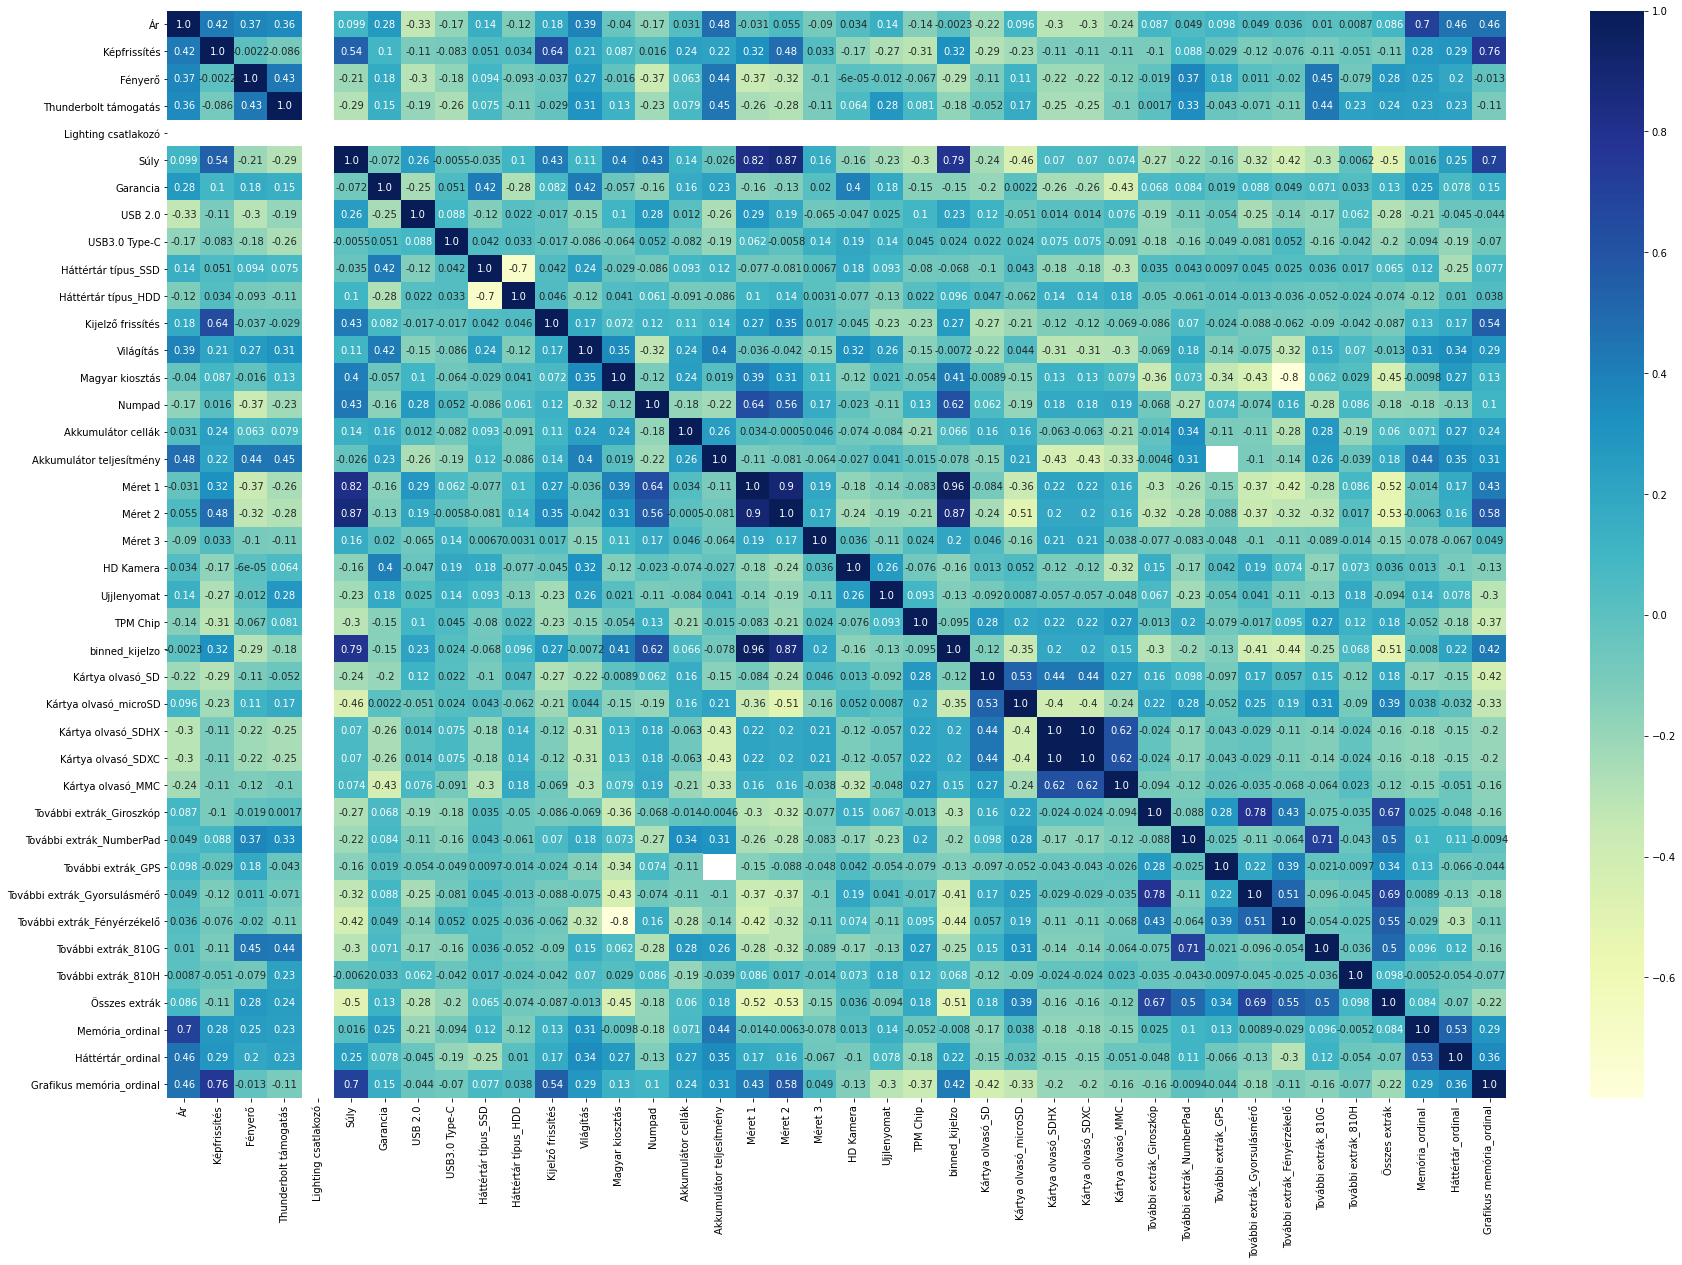

In [161]:
# show heatmap of given dataframe
def plot_heatmap(df1):
    fig = plt.figure(figsize=(30,20)) 
    corr = df1.corr()
    sns.heatmap(corr, cmap='YlGnBu', annot=True, fmt='.2')
    plt.show()

plot_heatmap(df1)

On the above plot we can see the correlation between the features. We are most interested in what correlation the price has with other features. We can see that  memory size, refresh rate, RAM size, storage size and VRAM are highly correlated with the price, however the extras have a small correlation (this does not surprise us though). 

One thing that's interesting is that battery performance is also an important metric when predicting the price. 

In [162]:
# show feature importance of a given target feature
def feature_importance_with_target(df1, target):
    df_corr = df1.corr()
    print(df_corr.loc[:,target].sort_values(ascending=False))

feature_importance_with_target(df1, 'Ár')

Ár                              1.000000
Memória_ordinal                 0.702985
Akkumulátor teljesítmény        0.484409
Háttértár_ordinal               0.464910
Grafikus memória_ordinal        0.462295
Képfrissítés                    0.419414
Világítás                       0.389684
Fényerő                         0.373179
Thunderbolt támogatás           0.355904
Garancia                        0.275210
Kijelző frissítés               0.178766
Háttértár típus_SSD             0.144928
Ujjlenyomat                     0.136918
Súly                            0.098816
További extrák_GPS              0.098255
Kártya olvasó_microSD           0.095603
További extrák_Giroszkóp        0.086609
Összes extrák                   0.086339
Méret 2                         0.055117
További extrák_Gyorsulásmérő    0.049368
További extrák_NumberPad        0.049003
További extrák_Fényérzékelő     0.035970
HD Kamera                       0.034209
Akkumulátor cellák              0.031435
További extrák_8

In [163]:
# filter columns of a given type
# count how many rows are required for plotting
def get_columns_with_required_rows(df1, col_type, plots_per_row=4):
    filtered_data = df1.select_dtypes([col_type])
    required_rows = (len(filtered_data.columns.values)//plots_per_row) + 1

    return filtered_data.columns.values, required_rows

# plot histplot of numerical features
def numerical_plots(df1, plots_per_row):
    numerical_cols, required_rows = get_columns_with_required_rows(df1, 'number', plots_per_row)

    fig, axs = plt. subplots(required_rows, plots_per_row, figsize=(16,20))

    for var, ax in zip(numerical_cols, axs.flatten()):
        sns.histplot(df1[var], ax=ax)

    plt.tight_layout()
    plt.show()


# plot countplot of categorical features
def categorical_countplots(df1, plots_per_row):
    categorical_cols, required_rows = get_columns_with_required_rows(df1, 'category', plots_per_row)

    fig, axs = plt.subplots(required_rows, plots_per_row, figsize=(22,30))  # default 
    for var, ax in zip(categorical_cols, axs.flatten()):
        sns.countplot(df1[var], ax=ax)
        for label in ax.get_xticklabels():
            label.set_rotation(90)

    plt.tight_layout()
    plt.show()

# show boxplot in connection with the target value
def boxplot_with_target(df1, target, plots_per_row=4):
    categorical_cols, required_rows = get_columns_with_required_rows(df1, 'category', plots_per_row)

    fig, axs = plt.subplots(required_rows, plots_per_row, figsize=(22,30))
    for var, ax in zip(categorical_cols, axs.flatten()):
        sns.boxplot(x=var, y=target, data=df1, ax=ax)
        for label in ax.get_xticklabels():
            label.set_rotation(90)

    plt.tight_layout()
    plt.show()

# not used
def conditional_plot(df1, target_col, other_target, cond_col):
    cond_plot = sns.FacetGrid(data=df1, col=cond_col, col_wrap=4)
    cond_plot.map(sns.scatterplot, target, other_target)



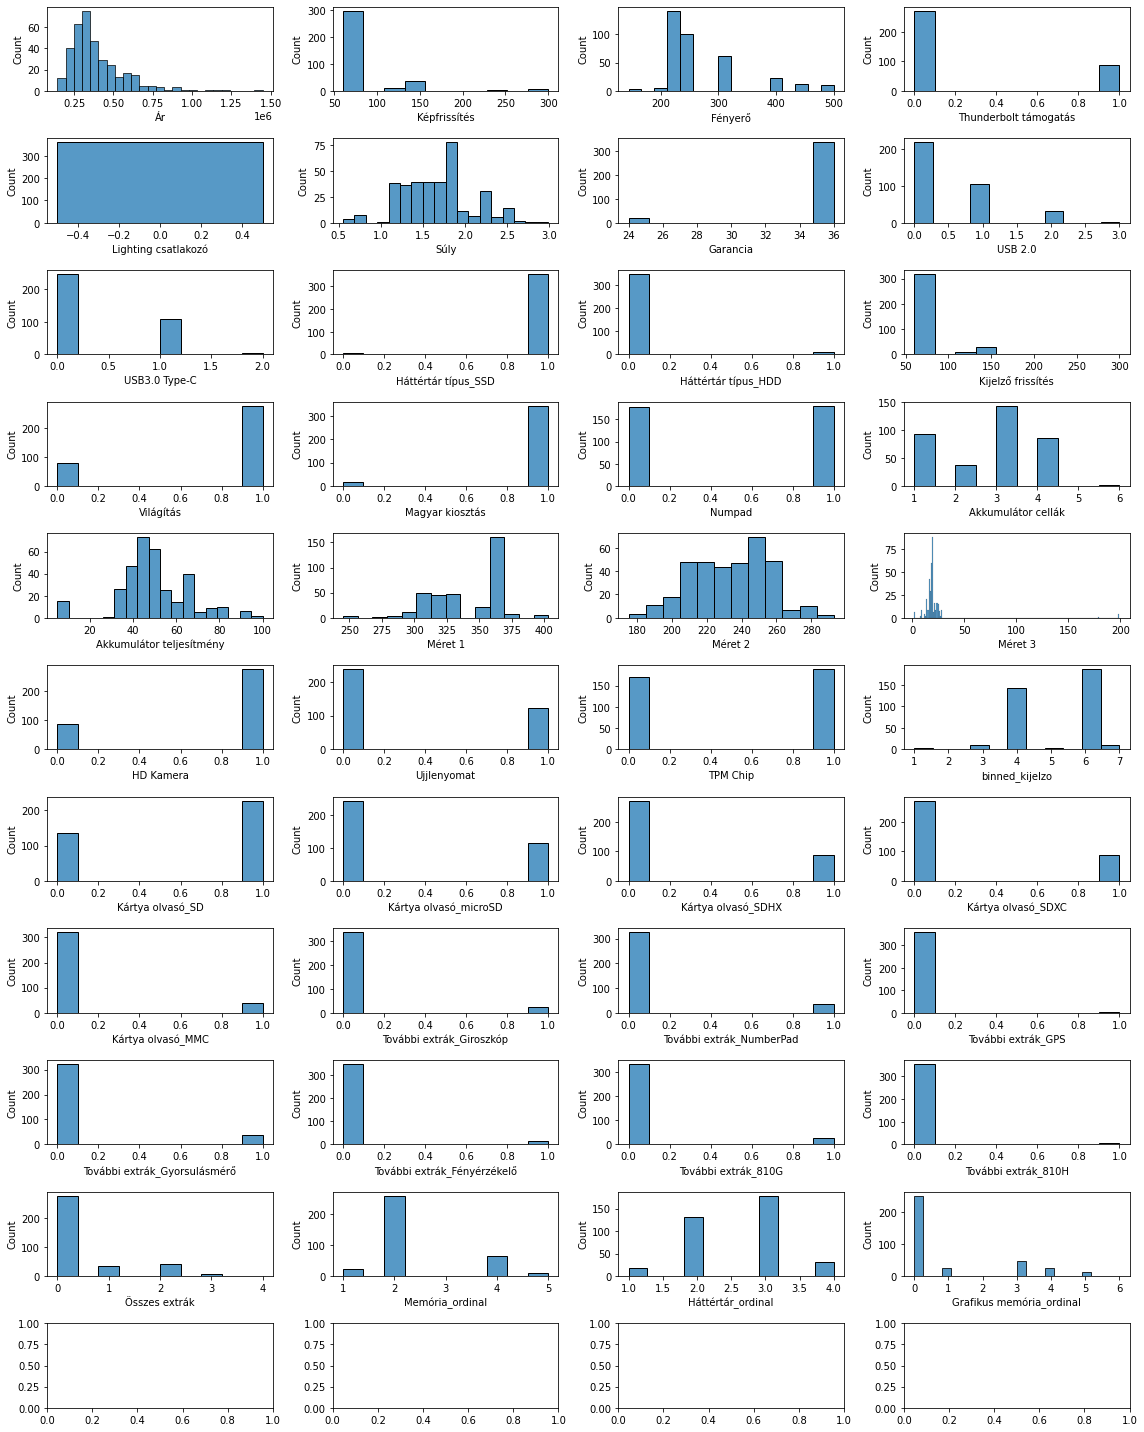

In [164]:
numerical_plots(df1, 4)

The most important fact from the plots above is that there are a couple of heavy outliers in 'Meret 3'. We must correct those!

Also the 'Lightning csatlakozó' feature has been showing weird things on every plot, I checked it out and all the values are missing. I will delete this feature.

The prices are right skewed, the other plots are easy to understand. 

In [165]:
# after the vizualisations some additional
# data cleaning is required
def additional_cleaning(df1):
    del df1['Lighting csatlakozó']

    df1['Méret 3'] = df1['Méret 3'].replace([199.00, 179.00], 19.00) # outlier due to typo
    delete_row = df1[df1['Ár'] == df1['Ár'].max()].index
    df1 = df1.drop(delete_row)

    return df1

df1 = additional_cleaning(df1)

In [166]:
# fill missing values 
def fill_na_values(df1):
    df1['Memória_ordinal'] = df1['Memória_ordinal'].fillna(1) # smallest ordinal value
    
    df1['Grafikus típus'] = df1['Grafikus típus'].cat.add_categories('No type') # create new type (probably not given due to no graph card )
    df1['Grafikus típus'] = df1['Grafikus típus'].fillna('No type') 

    df1['Optikai meghajtó'] = df1['Optikai meghajtó'].cat.add_categories('No optical drive')
    df1['Optikai meghajtó'] = df1['Optikai meghajtó'].fillna('No optical drive')
    
    fill_mean_columns = ['Akkumulátor teljesítmény', 'Méret 1', 'Méret 2', 'Méret 3'] # numerical features, we should fill with the mean (no other obvious option)
    for item in fill_mean_columns:
        df1[item] = df1[item].fillna(df1[item].mean())
    
    return df1

df1 = fill_na_values(df1)  
df1.isna().sum()

Ár                              0
Operációs rendszer              0
Képfrissítés                    0
Fényerő                         0
Wi-Fi                           0
Thunderbolt támogatás           0
Optikai meghajtó                0
Súly                            0
Garancia                        0
USB 2.0                         0
USB3.0 Type-C                   0
Memória DDR                     0
Háttértár típus_SSD             0
Háttértár típus_HDD             0
Processzor márka                0
Processzor típus                0
Grafikus márka                  0
Grafikus típus                  0
Kijelző felbontás               0
Kijelző frissítés               0
Világítás                       0
Magyar kiosztás                 0
Numpad                          0
Akkumulátor cellák              0
Akkumulátor teljesítmény        0
Méret 1                         0
Méret 2                         0
Méret 3                         0
HD Kamera                       0
Ujjlenyomat   

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


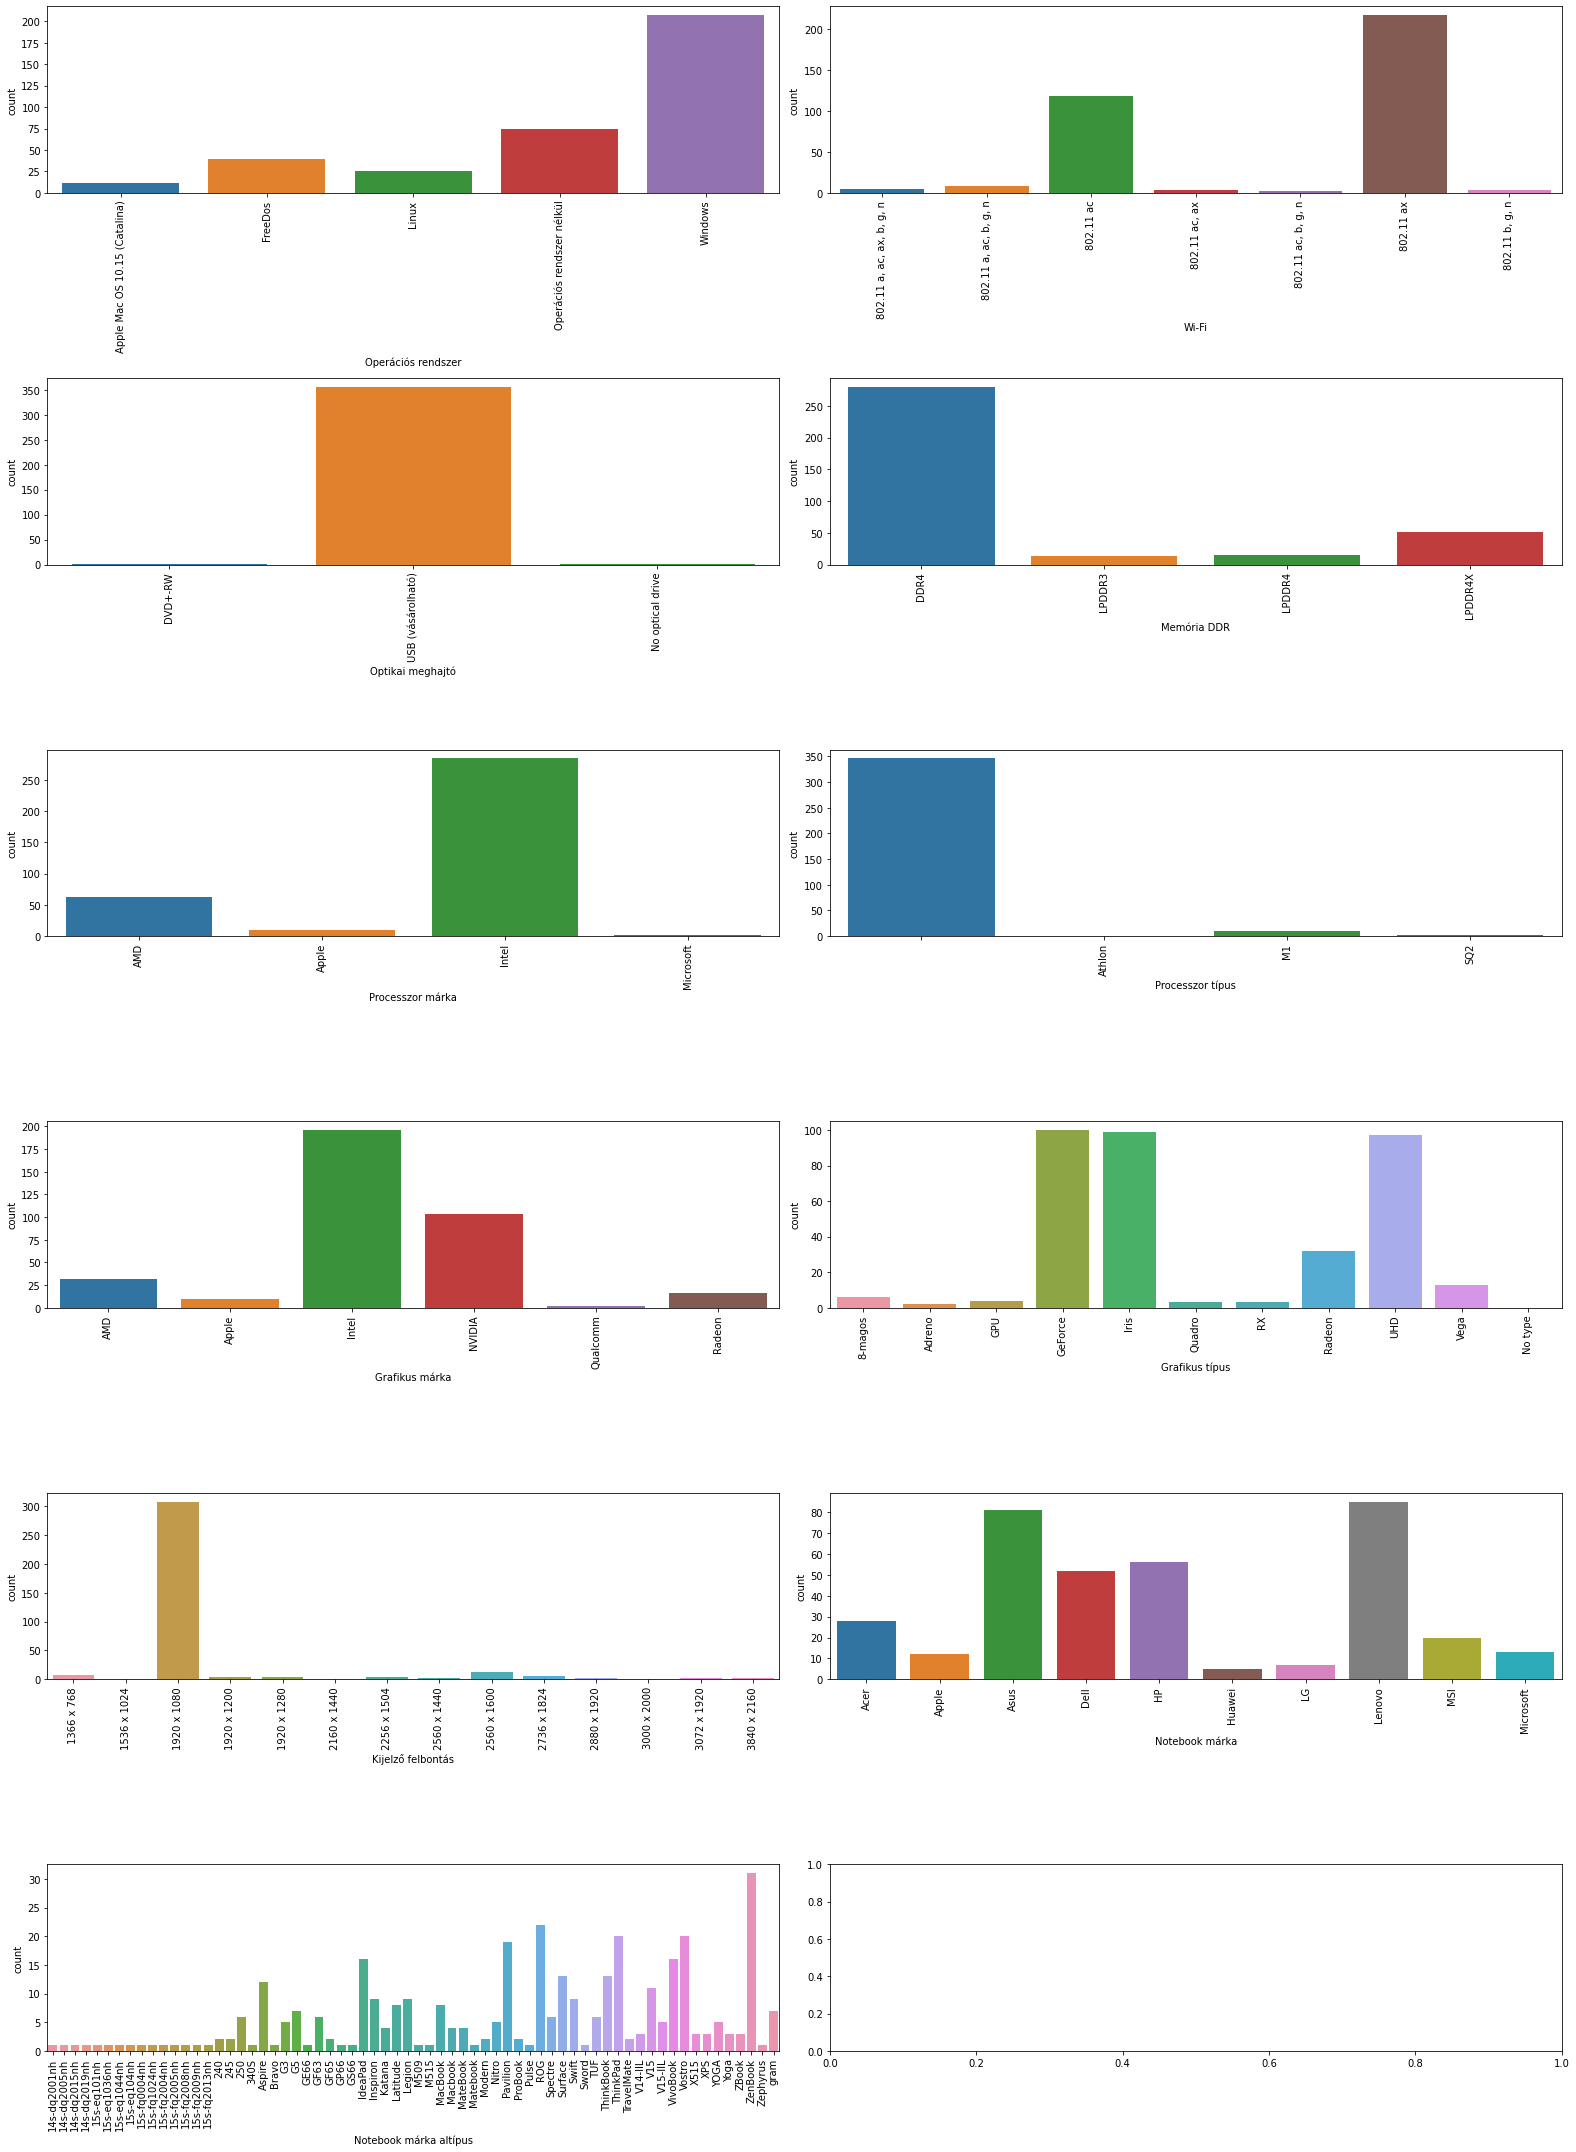

In [167]:
categorical_countplots(df1, 2)

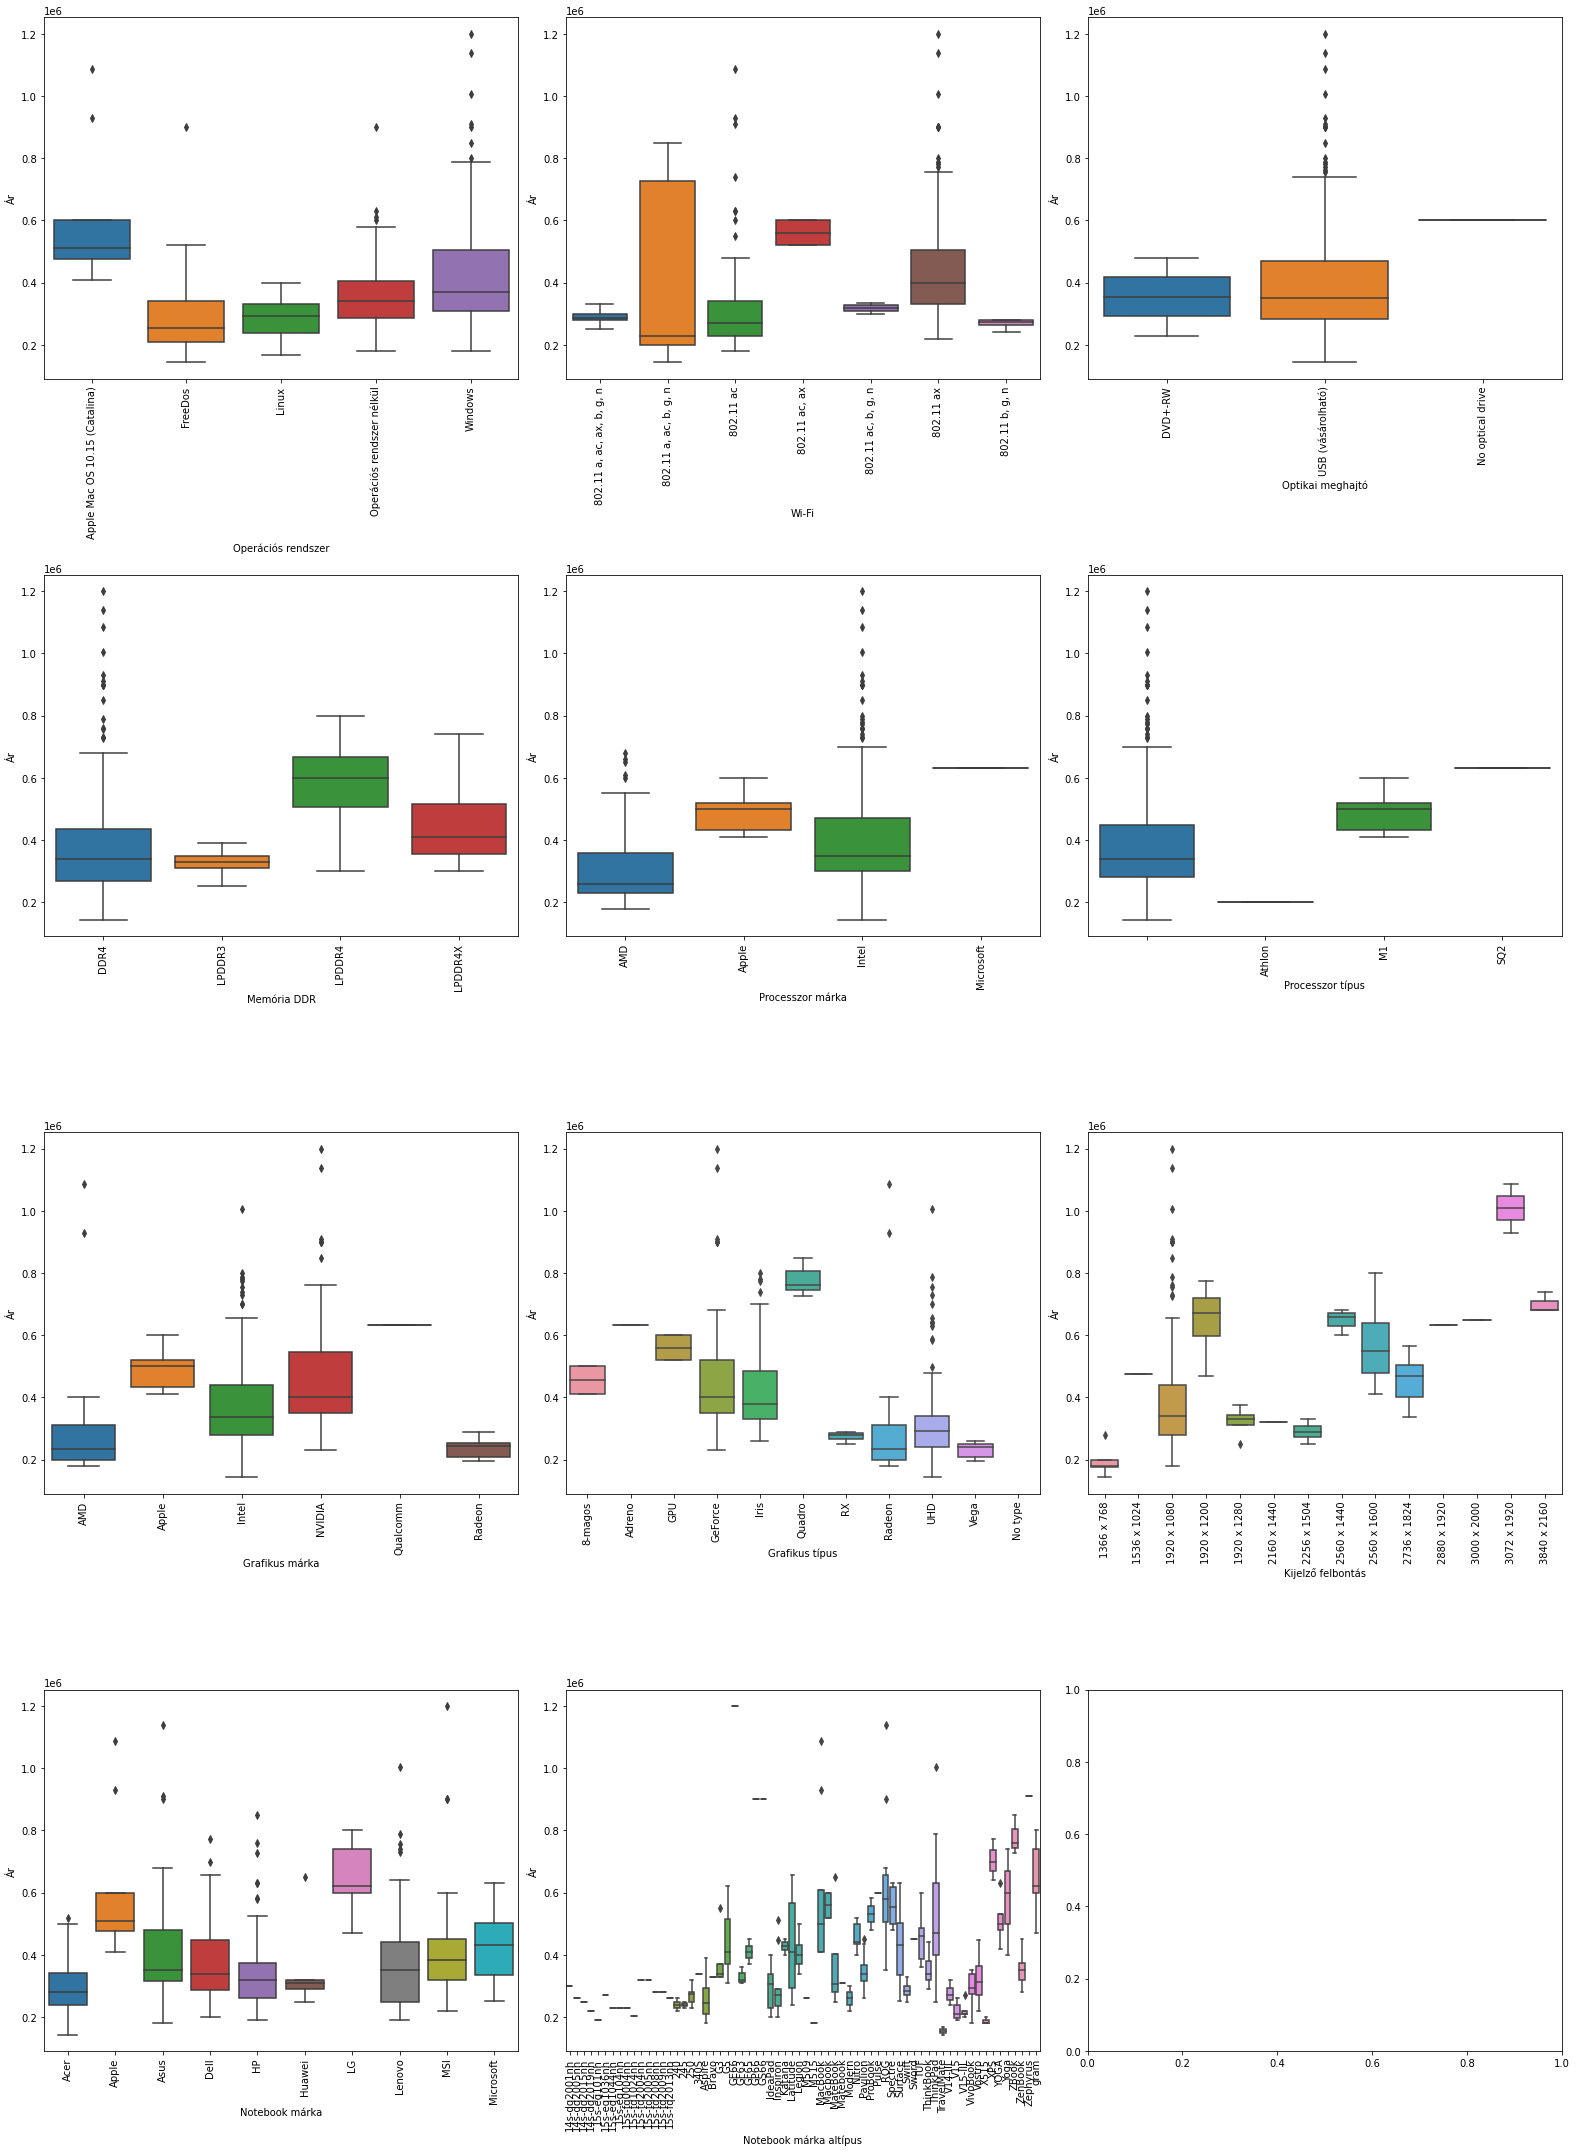

In [168]:
boxplot_with_target(df1, 'Ár', 3)

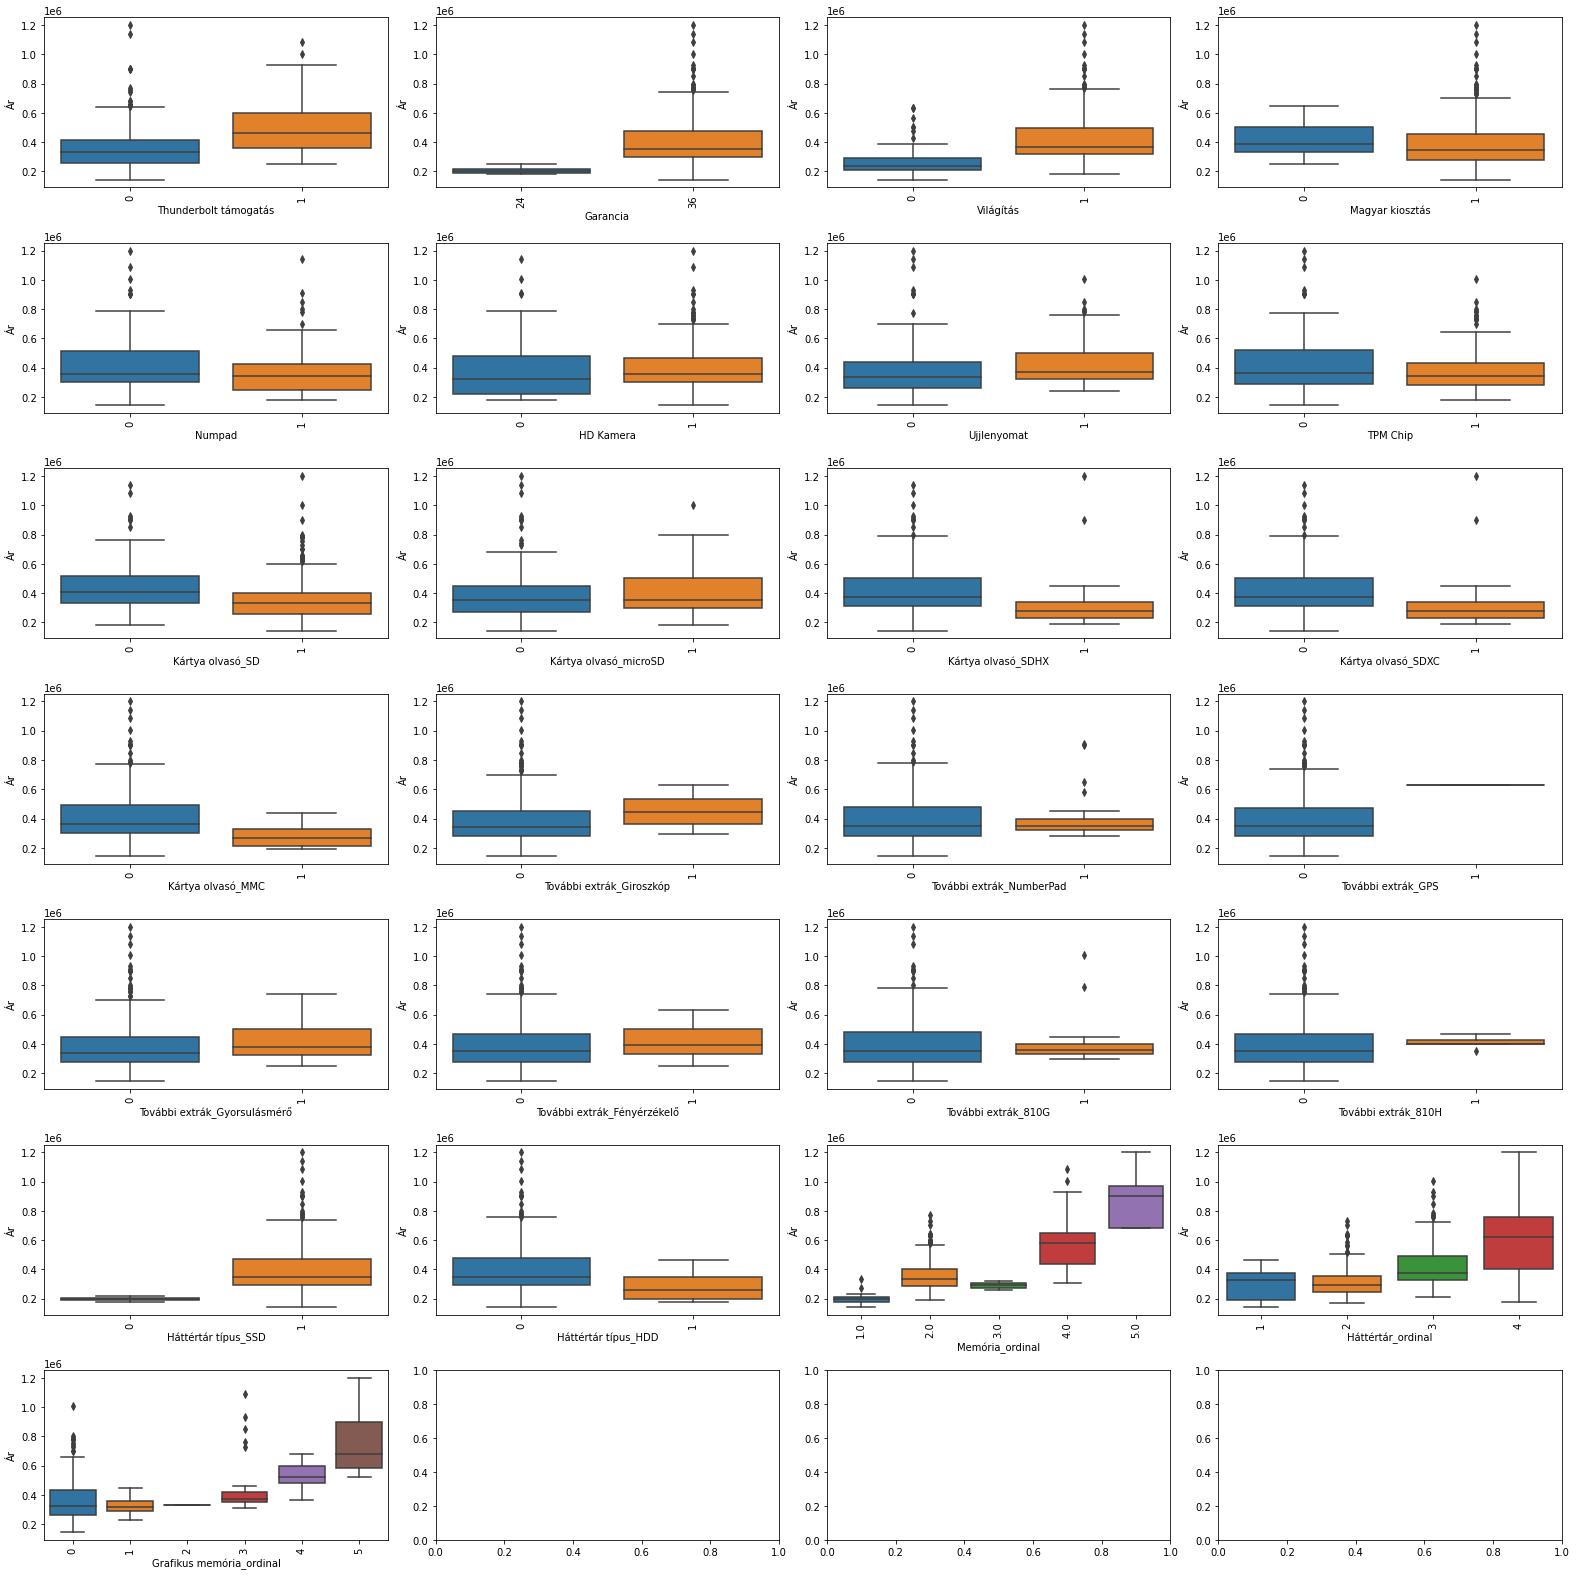

In [169]:
# some numerical features contain yes/no information
# it's to know interesting whether a tool drives the price higher or not
def fake_numerical_col_boxplot(df1, target, plots_per_row=4):
    cols = ['Thunderbolt támogatás', 'Garancia', 'Világítás', 'Magyar kiosztás', 'Numpad', 'HD Kamera', 
            'Ujjlenyomat', 'TPM Chip', 'Kártya olvasó_SD', 'Kártya olvasó_microSD', 'Kártya olvasó_SDHX', 
            'Kártya olvasó_SDXC', 'Kártya olvasó_MMC', 'További extrák_Giroszkóp', 'További extrák_NumberPad', 
            'További extrák_GPS', 'További extrák_Gyorsulásmérő', 'További extrák_Fényérzékelő', 'További extrák_810G', 
            'További extrák_810H', 'Háttértár típus_SSD', 'Háttértár típus_HDD', 'Memória_ordinal', 'Háttértár_ordinal',
            'Grafikus memória_ordinal']
    
    required_rows = (len(cols)//plots_per_row) + 1 

    fig, axs = plt.subplots(required_rows, plots_per_row, figsize=(22,22))
    for var, ax in zip(cols, axs.flatten()):
        sns.boxplot(x=var, y=target, data=df1, ax=ax)
        for label in ax.get_xticklabels():
            label.set_rotation(90)

    plt.tight_layout()
    plt.show()

fake_numerical_col_boxplot(df1, 'Ár')

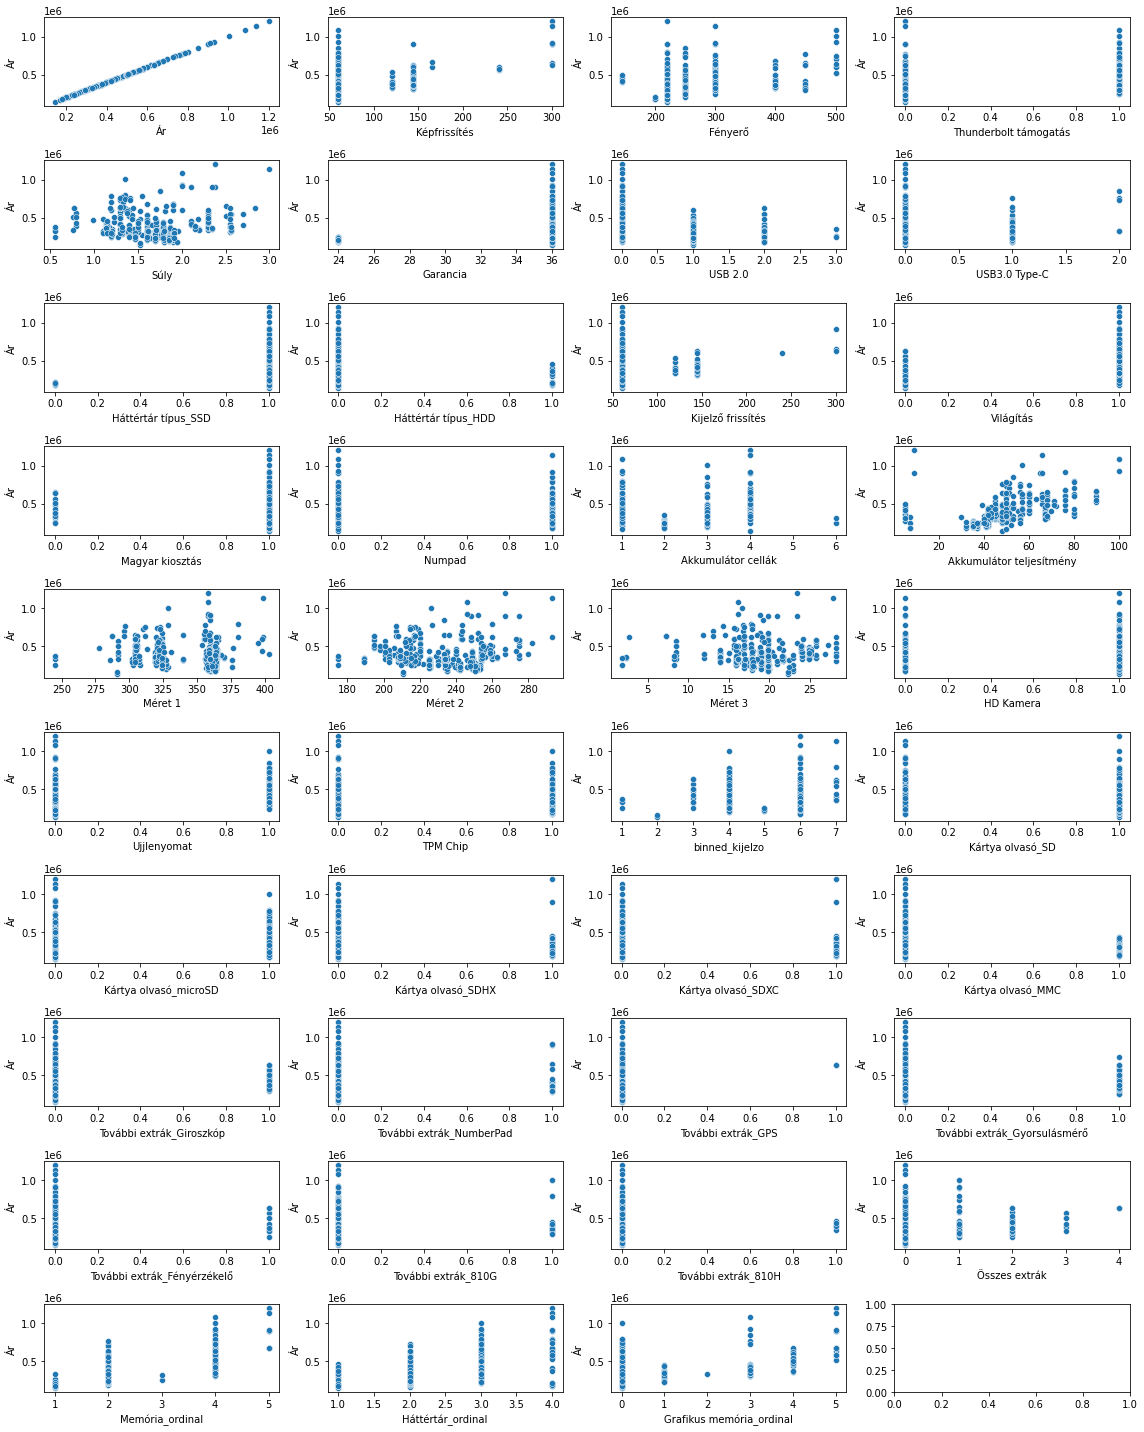

In [170]:
# plot scatterplot of numerical features with target feature
def scatterplots(df1, target, plots_per_row=4):
    numerical_cols, required_rows = get_columns_with_required_rows(df1, 'number', plots_per_row)

    fig, axs = plt. subplots(required_rows, plots_per_row, figsize=(16,20))

    for var, ax in zip(numerical_cols, axs.flatten()):
        sns.scatterplot(x=df1[var],y=df1[target], ax=ax)

    plt.tight_layout()
    plt.show()

scatterplots(df1, 'Ár')

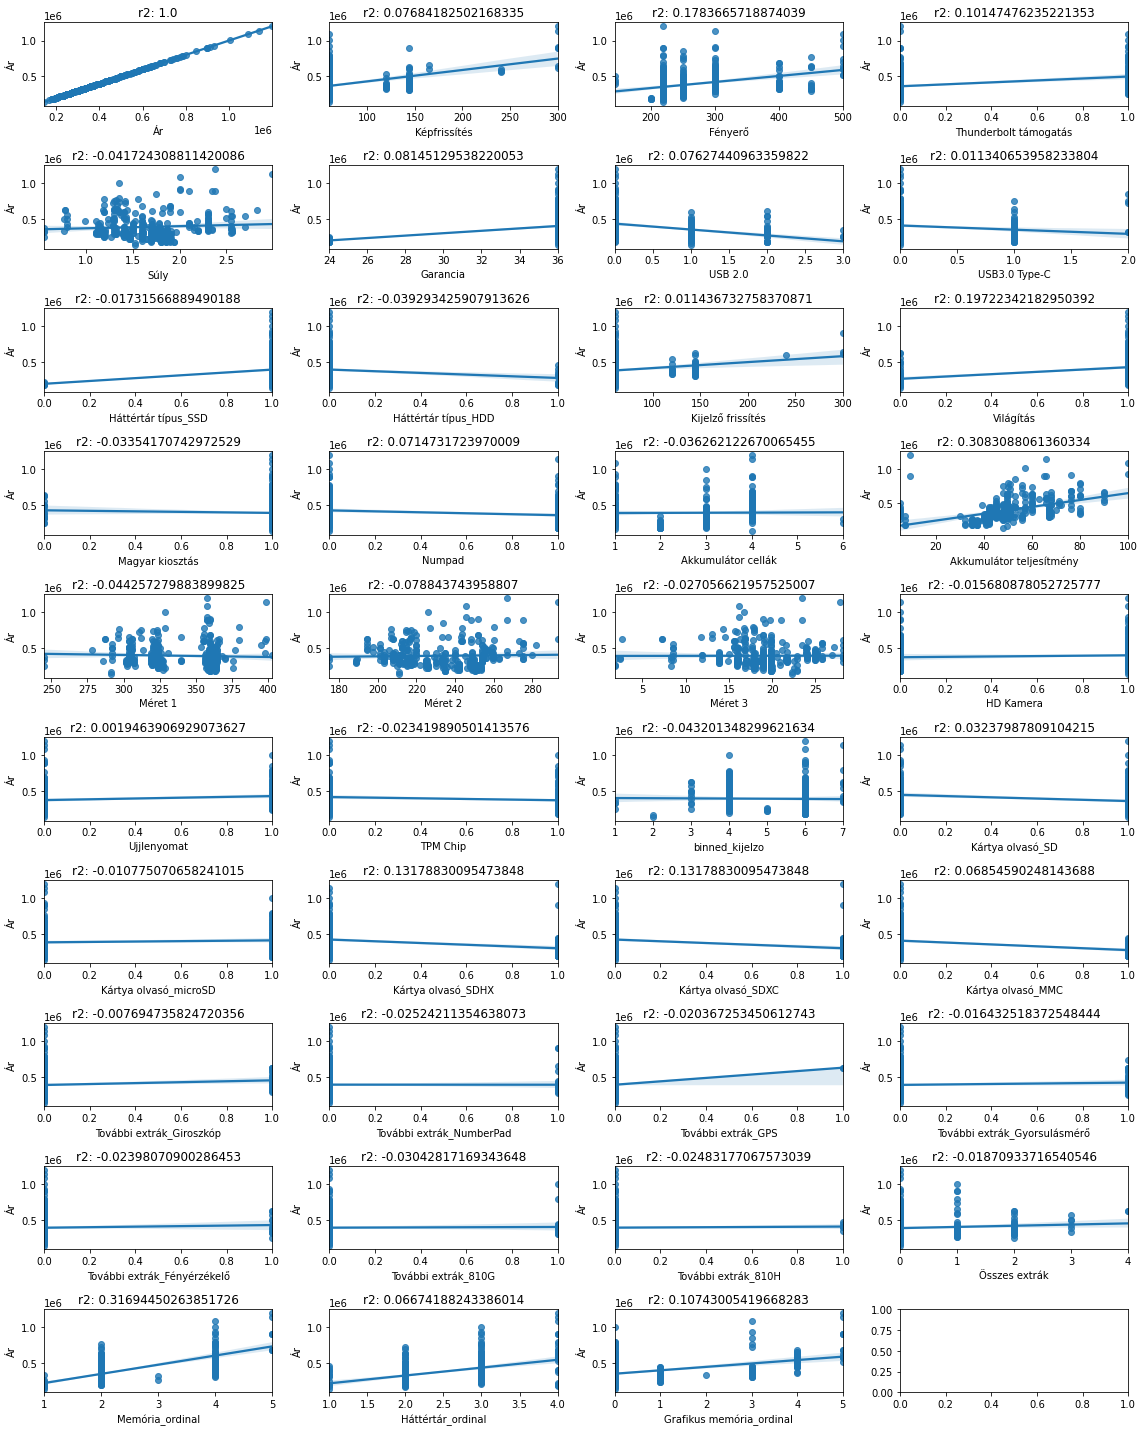

In [171]:
# show regplot with r squared value
def regplot_with_r2(df1, target, plots_per_row=4):
    numerical_cols, required_rows = get_columns_with_required_rows(df1, 'number', plots_per_row)

    fig, axs = plt. subplots(required_rows, plots_per_row, figsize=(16,20))

    scaler = MinMaxScaler(feature_range=(0, 1))

    for var, ax in zip(numerical_cols, axs.flatten()):
        X_train, X_test, y_train, y_test = train_test_split(df1[var], df1[target], test_size=0.33, random_state=1234)
        X_train = X_train.values.reshape(-1,1)
        X_test = X_test.values.reshape(-1,1)
        lin_reg = linear_model.LinearRegression()
        lin_reg.fit(X_train, y_train)
        y_pred = lin_reg.predict(X_test)
        sns.regplot(x=df1[var],y=df1[target], ax=ax).set_title(f"r2: {r2_score(y_test, y_pred)}")

    plt.tight_layout()
    plt.show()

regplot_with_r2(df1, 'Ár')

# cross validation with random forest 

In [172]:
# one-hot-encode categorical features
def one_hot_converter(df1):
    df = df1.copy()
    categorical_cols = df.select_dtypes(['category'])
    
    for col in categorical_cols.columns.values:
        dummies = pd.get_dummies(df[col], prefix=col)
        df = pd.concat([df, dummies], axis=1)
        del df[col]
    
    return df 

df1 = one_hot_converter(df1)

In [173]:
from sklearn.model_selection import KFold

kf = KFold(10, shuffle=True)

df_preds = pd.DataFrame()
target = 'Ár'
for train_idx, test_idx in kf.split(df1):
  train_data = df1.iloc[train_idx]
  test_data = df1.iloc[test_idx]

  rf_model = RandomForestRegressor()
  rf_model.fit(train_data.loc[:, df1.columns != 'Ár'], train_data['Ár'])
  test_data['preds'] = pd.DataFrame(rf_model.predict(test_data.loc[:, df1.columns != 'Ár']), index=test_data.index)
  df_preds = df_preds.append(test_data)
df_preds.shape  

# TODO: fix SettingsWithCopyWarning


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

(359, 174)

In [174]:
print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(df_preds[target], df_preds['preds']))
print('Mean Squared Error (MSE):', metrics.mean_squared_error(df_preds[target], df_preds['preds']))
print('Root Mean Squared Error (RMSE):', np.sqrt(metrics.mean_squared_error(df_preds[target], df_preds['preds'])))
print('R2 Score:', r2_score(df_preds[target], df_preds['preds']))

Mean Absolute Error (MAE): 45534.368136196834
Mean Squared Error (MSE): 5544283690.343618
Root Mean Squared Error (RMSE): 74459.9468865216
R2 Score: 0.8065529489829844


In [175]:
# Hyperparameter optimization with RandomizerSearchCV 
# (GridSearchCV could be used after)

from sklearn.model_selection import RandomizedSearchCV

X = df1.loc[:, df1.columns != 'Ár']
y = df1.loc[:, 'Ár']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1234)

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 1, stop = 200, num = 100)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(1, 100, num = 10)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=1234, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:   25.7s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   44.6s finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100,
                              

In [176]:
rf_random.best_params_

{'bootstrap': False,
 'max_depth': 45,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 169}

In [177]:
X_test

,Képfrissítés,Fényerő,Thunderbolt támogatás,Súly,Garancia,USB 2.0,USB3.0 Type-C,Háttértár típus_SSD,Háttértár típus_HDD,Kijelző frissítés,Világítás,Magyar kiosztás,Numpad,Akkumulátor cellák,Akkumulátor teljesítmény,Méret 1,Méret 2,Méret 3,HD Kamera,Ujjlenyomat,TPM Chip,binned_kijelzo,Kártya olvasó_SD,Kártya olvasó_microSD,Kártya olvasó_SDHX,Kártya olvasó_SDXC,Kártya olvasó_MMC,További extrák_Giroszkóp,További extrák_NumberPad,További extrák_GPS,További extrák_Gyorsulásmérő,További extrák_Fényérzékelő,További extrák_810G,További extrák_810H,Összes extrák,Memória_ordinal,Háttértár_ordinal,Grafikus memória_ordinal,Operációs rendszer_Apple Mac OS 10.15 (Catalina),Operációs rendszer_FreeDos,...,Notebook márka altípus_GP66,Notebook márka altípus_GS66,Notebook márka altípus_IdeaPad,Notebook márka altípus_Inspiron,Notebook márka altípus_Katana,Notebook márka altípus_Latitude,Notebook márka altípus_Legion,Notebook márka altípus_M509,Notebook márka altípus_M515,Notebook márka altípus_MacBook,Notebook márka altípus_Macbook,Notebook márka altípus_MateBook,Notebook márka altípus_Matebook,Notebook márka altípus_Modern,Notebook márka altípus_Nitro,Notebook márka altípus_Pavilion,Notebook márka altípus_ProBook,Notebook márka altípus_Pulse,Notebook márka altípus_ROG,Notebook márka altípus_Spectre,Notebook márka altípus_Surface,Notebook márka altípus_Swift,Notebook márka altípus_Sword,Notebook márka altípus_TUF,Notebook márka altípus_ThinkBook,Notebook márka altípus_ThinkPad,Notebook márka altípus_TravelMate,Notebook márka altípus_V14-IIL,Notebook márka altípus_V15,Notebook márka altípus_V15-IIL,Notebook márka altípus_VivoBook,Notebook márka altípus_Vostro,Notebook márka altípus_X515,Notebook márka altípus_XPS,Notebook márka altípus_YOGA,Notebook márka altípus_Yoga,Notebook márka altípus_ZBook,Notebook márka altípus_ZenBook,Notebook márka altípus_Zephyrus,Notebook márka altípus_gram
140,60,250,1,1.70,36,0,0,1,0,60,1,1,1,3,45.0,357.00,235.00,18.90,1,1,1,6,1,0,1,1,1,0,0,0,0,0,0,0,0,4.0,3,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
54,120,250,0,2.20,36,0,1,1,1,120,1,1,1,1,45.0,359.00,249.00,24.90,1,0,0,6,0,0,0,0,0,0,0,0,0,0,0,0,0,2.0,1,3,0,1,...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
22,144,300,0,2.30,36,0,1,1,0,60,1,1,1,1,80.0,363.06,259.61,24.00,1,0,1,6,0,0,0,0,0,0,0,0,0,0,0,0,0,2.0,2,3,0,0,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
129,60,500,0,1.35,36,0,0,1,0,60,1,1,0,1,60.0,320.30,215.60,15.70,1,1,1,4,0,0,0,0,0,0,0,0,1,0,0,0,1,4.0,3,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
7,120,300,0,1.60,36,0,0,1,0,120,1,1,0,4,76.0,324.00,220.00,19.90,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,2.0,3,4,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80,60,400,0,1.90,36,0,0,1,0,60,1,1,0,4,76.0,360.00,252.00,18.90,0,0,0,6,0,0,0,0,0,0,0,0,0,0,0,0,0,5.0,4,5,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
318,60,300,0,1.80,36,2,1,1,0,60,1,1,1,3,50.0,359.80,233.80,16.10,1,1,1,6,1,1,0,0,0,0,0,0,0,0,0,0,0,2.0,3,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
9,144,220,0,2.38,36,0,0,1,0,60,1,1,0,1,65.0,358.00,267.00,23.40,1,0,0,6,0,0,0,0,0,0,0,0,0,0,0,0,0,4.0,3,5,0,1,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
29,144,300,0,2.30,36,0,1,1,0,144,1,1,1,1,60.0,363.06,259.61,24.00,1,0,1,6,0,0,0,0,0,0,0,0,0,0,0,0,0,2.0,2,3,0,0,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [178]:
prediction = pd.DataFrame(rf_random.predict(X_test))
print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(y_test, prediction))
print('Mean Squared Error (MSE):', metrics.mean_squared_error(y_test, prediction))
print('Root Mean Squared Error (RMSE):', np.sqrt(metrics.mean_squared_error(y_test, prediction)))
print('R2 Score:', r2_score(y_test, prediction))

Mean Absolute Error (MAE): 37975.3908247498
Mean Squared Error (MSE): 3572289145.8996224
Root Mean Squared Error (RMSE): 59768.630115635264
R2 Score: 0.8254936319156311


In [179]:
res = pd.DataFrame(y_test)
res = res.reset_index()
res['pred'] = prediction
del res['index']
res

,Ár,pred
0,439900,448249.112426
1,339900,354647.534517
2,339900,390189.940828
3,599900,702337.869822
4,479900,498255.029586
...,...,...
103,679900,687462.130178
104,319900,327361.538462
105,899900,596086.390533
106,399900,409734.319527


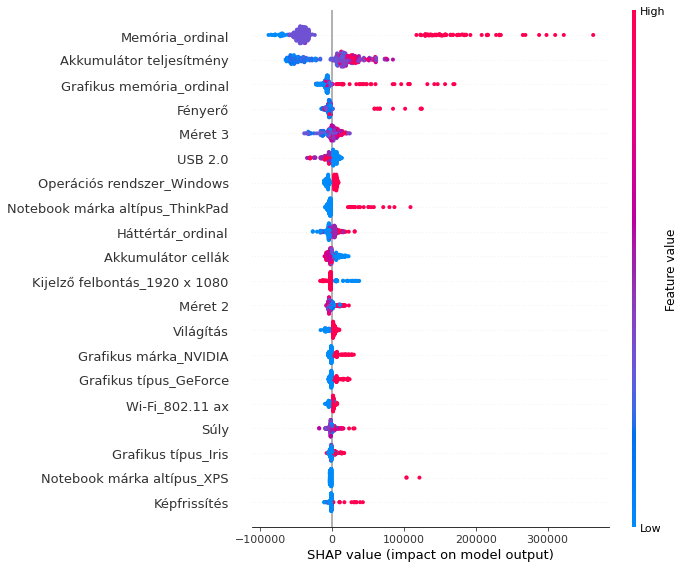

In [180]:
# model interpretation with SHAP 

!pip install shap

import shap
shap.initjs()

def shap_explainer_RFR(df1, target, model):
    model = RandomForestRegressor()
    model.fit(df1.loc[:, df1.columns != target], df1[target])
    explainer = shap.TreeExplainer(model, df1.loc[:, df1.columns != target])
    shap_values = explainer.shap_values(df1.loc[:, df1.columns != target])

    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(df1.loc[:, df1.columns != target])

    shap.summary_plot(shap_values, df1.loc[:, df1.columns != target], max_display=20)

shap_explainer_RFR(df1, 'Ár', rf_random)

In [181]:
import pickle

pickle.dump(rf_random, open('model.pkl', 'wb'))

(None,)

I'm pretty sure the model can be improved by converting some categorical features (that are right now one-hot encoded) to ordinal features as RF usually performs better with those. 

Obviously feature selection and hyperparameter optimization (for example with GridSearchCV) would also help yield better results. 

# cross validation XGBoost

In [182]:
from xgboost import XGBRegressor

kf = KFold(10, shuffle=True)

df_preds = pd.DataFrame()
target = 'Ár'
for train_idx, test_idx in kf.split(df1):
  train_data = df1.iloc[train_idx]
  test_data = df1.iloc[test_idx]

  xgb_model = XGBRegressor()
  xgb_model.fit(train_data.loc[:, df1.columns != 'Ár'], train_data['Ár'])
  test_data['preds'] = pd.DataFrame(xgb_model.predict(test_data.loc[:, df1.columns != 'Ár']), index=test_data.index)
  df_preds = df_preds.append(test_data)
df_preds.shape  

print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(df_preds[target], df_preds['preds']))
print('Mean Squared Error (MSE):', metrics.mean_squared_error(df_preds[target], df_preds['preds']))
print('Root Mean Squared Error (RMSE):', np.sqrt(metrics.mean_squared_error(df_preds[target], df_preds['preds'])))
mape = np.mean(np.abs((df_preds[target] - df_preds['preds']) / np.abs(df_preds[target])))
print('Mean Absolute Percentage Error (MAPE):', round(mape * 100, 2))
print('Accuracy:', round(100*(1 - mape), 2))
print('R2 Score:', r2_score(df_preds[target], df_preds['preds']))

[14:55:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:55:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


[14:55:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:55:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:55:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:55:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:55:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:55:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:55:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:55:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

In [183]:
!pip install pycaret

import pycaret
from pycaret.regression import *

# setup the dataset
grid = setup(data=df1, target='Ár', feature_selection=True)

# evaluate models and compare models
best = compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,4.935956e+04,5.556501e+09,7.232023e+04,0.8129,0.1562,0.1207,0.104
et,Extra Trees Regressor,4.844228e+04,5.621315e+09,7.407581e+04,0.8003,0.1561,0.1145,0.549
ridge,Ridge Regression,5.384990e+04,6.075673e+09,7.579670e+04,0.7905,0.1958,0.1400,0.016
br,Bayesian Ridge,5.422942e+04,6.195035e+09,7.654867e+04,0.7870,0.1961,0.1407,0.058
rf,Random Forest Regressor,5.270169e+04,6.735327e+09,7.954748e+04,0.7762,0.1664,0.1260,0.535
lightgbm,Light Gradient Boosting Machine,5.856270e+04,8.179904e+09,8.827434e+04,0.7169,0.1897,0.1444,0.085
omp,Orthogonal Matching Pursuit,6.415999e+04,8.437549e+09,9.045384e+04,0.7092,0.2004,0.1578,0.015
huber,Huber Regressor,6.243827e+04,9.516254e+09,9.283455e+04,0.7087,0.1925,0.1457,0.063
ada,AdaBoost Regressor,7.368735e+04,9.269298e+09,9.405919e+04,0.6805,0.2340,0.2074,0.106
en,Elastic Net,7.187977e+04,1.120030e+10,9.930421e+04,0.6667,0.2127,0.1782,0.022
